# Julia 1.6.5

In [ ]:
using Plots; pyplot()
using Plots.Measures
using DelimitedFiles, DataFrames, CSV, JLD
using StatsBase    
using Combinatorics
using ProgressMeter
using LaTeXStrings

# Sequencing output quality control

#### Mean coverage of deduplicated alignments per chromosome per individual

In [2]:
dir_source="/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/02_bams"

cd(dir_source)

In [3]:
sp_4 = readdlm("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/LIST/SampleNames_Group4.txt")
sp_3 = readdlm("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/LIST/SampleNames_Group3.txt")
sp_2 = readdlm("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/LIST/SampleNames_Group2.txt")
sp_1 = readdlm("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/LIST/SampleNames_Group1.txt")

sp = sp_1[:,1]


335-element Vector{Any}:
 "DDB001_S1"
 "DDB008_S2"
 "DDB009_S3"
 "DDB010_S4"
 "DDB011_S5"
 "DDB015_S6"
 "DDB017_S7"
 "DDB018_S8"
 "DDB023_S9"
 "DDB024_S10"
 "DDB025_S11"
 "DDB026_S12"
 "DDB027_S13"
 ⋮
 "BDB070_S324"
 "BDB071_S325"
 "BDB072_S326"
 "BDB073_S327"
 "BDB075_S328"
 "BDB076_S329"
 "BDB077_S330"
 "BDB078_S331"
 "BDB079_S332"
 "BDB080_S333"
 "BDB081_S334"
 "BDB082_S335"

In [4]:
cov = zeros(30,0)
for i in 1:size(sp)[1]
    df = DataFrame(CSV.File(string(sp[i],".dedup.sorted.bam.q10Q10.coverage_summary")))
    cov = hcat(cov,df[1:30,7])
end

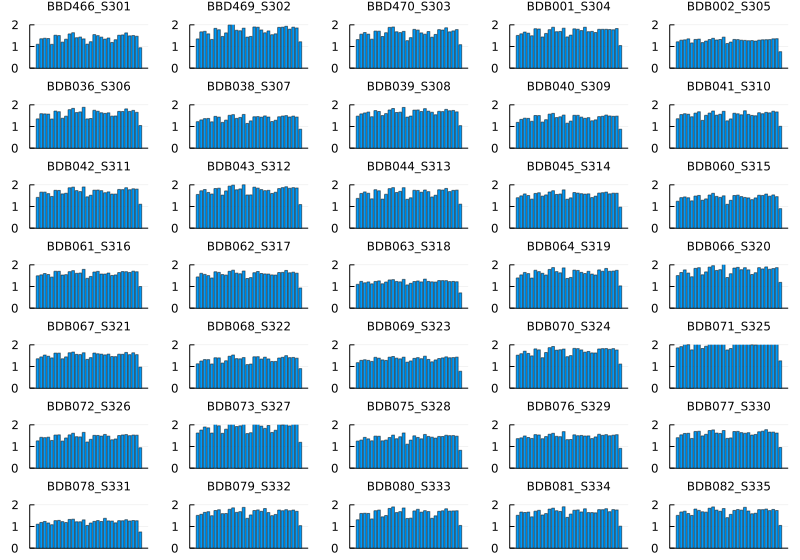

In [26]:
fig = plot(layout=(7,5),size=(800,800/10*7))

k=1
for i in 301:335
    bar!(fig,1:30,cov[1:30,i],label="",
        linealpha=0.5,
        linecolor=:black,
        # markercolor=:black,
        # marker=:circle,
        # markersize=3,
        ylims=(0,2),
        yticks=[0,1,2],
        xticks=[],
        title=sp[i],
        titlefontsize=8,
        subplot=k)
    k=k+1
end

fig

In [27]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/CoveragePerChromosome"

prefix = "/Group1.301-335.coverage"
savefig(fig,string(dir_output,prefix,".pdf"))
savefig(fig,string(dir_output,prefix,".png"))

#### Consanguinity analysis

In [121]:
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/04_IBD.NgsRelate"

cd(dir_source)

In [147]:
chr_list = 1:29
θ_all = zeros(68265,0)

sp1 = zeros(370)
sp2 = zeros(370)


k = 0

for chr in chr_list
    
    if isfile("Joint.HiC_scaffold_$(chr).snp.filtered2.vcf.gz.res.spill0.res")
        continue
    else

        df = DataFrame(CSV.File("Joint.HiC_scaffold_$(chr).snp.filtered2.vcf.gz.res"))

        if k == 0
            # convert output of ngsrelate's individual indices to my own sample indices
            sp1 = 370 .- df[!,:a]
            sp2 = 370 .- df[!,:b]
        end
        
        k = k+1

        θ = df[!,:theta]
        θ_all = hcat(θ_all,θ)
    end
end

println(k)

θ_average = dropdims(mean(θ_all;dims=2),dims=2);

29


In [14]:
df = DataFrame(CSV.File("/n/home00/txiong/Research/2022_HybridSterility/Individuals_ordered_by_family_beforeCorrection.csv"))

FamilyID = df[4:391,1]
IndividualID = df[4:391,2]
t = split.(IndividualID,"S")
sampleID = [i[2] for i in t];

In [148]:
function get_θ(sp_list_1,sp_list_2,θ_data,sampleID1,sampleID2)
    
    sampleID1 = parse(Int64,sampleID1)
    sampleID2 = parse(Int64,sampleID2)
    
    sampleID_min = min(sampleID1,sampleID2)
    sampleID_max = max(sampleID1,sampleID2)
    
    idx = findfirst((sampleID_max .== sp_list_1) .* (sampleID_min .== sp_list_2))
    return θ_data[idx]
end

function compare_family_to_family(f1,f2,FamilyID,sampleID)
    
    Samples1 = sampleID[FamilyID .== f1]
    Samples2 = sampleID[FamilyID .== f2]
    
    if f1 == f2
        
        N = size(Samples1)[1]
        
        K = zeros(N,N) .- 1
               
        for (i,j) in collect(combinations(1:N, 2))
            
            K[i,j] = get_θ(sp1,sp2,θ_average,Samples1[i],Samples1[j])
            
        end
        
    elseif f1 != f2
        
        N1 = size(Samples1)[1]
        N2 = size(Samples2)[1]
        
        K = zeros(N1,N2) .- 1
        
        for i in 1:N1
            for j in 1:N2
                if Samples1[i] == Samples2[j]
                    continue
                else
                    K[i,j] = get_θ(sp1,sp2,θ_average,Samples1[i],Samples2[j])
                end
            end
        end
        
    end
    
    return K,Samples1,Samples2
    
end

compare_family_to_family (generic function with 1 method)

In [127]:
f1 = "F07"
f2 = "F08"
K, members1, members2 = compare_family_to_family(f1,f2,FamilyID,sampleID)
K[K .== -1] .= NaN;

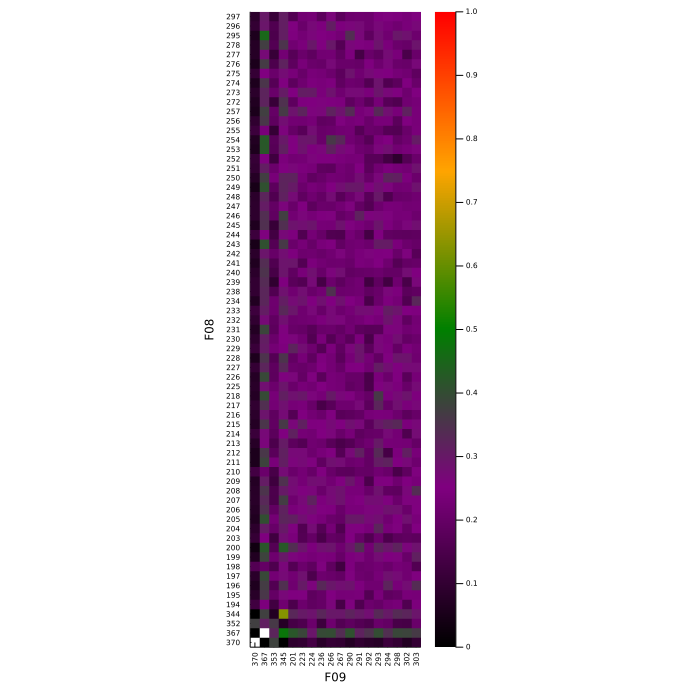

In [17]:
f1 = "F09"
f2 = "F08"
K, members1, members2 = compare_family_to_family(f1,f2,FamilyID,sampleID)
K[K .== -1] .= NaN;


fig = plot(size=(700,700))
color_scheme = cgrad([:black,:purple,:green,:orange,:red], rev=false)
heatmap!(fig,transpose(K),
    xticks=(1:size(members1)[1],members1),
    yticks=(1:size(members2)[1],members2),
    xlabel=f1,ylabel=f2,
    color=color_scheme,
    grid=:off,
    xguidefontsize=8,
    yguidefontsize=8,
    xtickfontsize=5,
    ytickfontsize=5,
    xrotation=90,
    aspect_ratio=1,
    xlims=(0.5,size(members1)[1]+0.5),
    ylims=(0.5,size(members2)[1]+0.5),
    clims=(-0.0,1.0))

#### Plot every individual together

In [142]:
df = DataFrame(CSV.File("/n/home00/txiong/Research/2022_HybridSterility/Individuals_ordered_by_family_plusPandGP_afterCorrection.csv"))

FamilyID = df[1:end,1]
IndividualID = df[1:end,2]
t = split.(IndividualID,"S")
sampleID = [i[2] for i in t];

In [143]:
family_border_idx = zeros(2,0)

for f in unique(FamilyID)
    idx = findall(FamilyID .== f)

    family_border_idx = hcat(family_border_idx,[minimum(idx),maximum(idx)])
end

family_border_idx = Int64.(family_border_idx);

In [149]:
K = zeros(370,370) .- 1

for (i,j) in combinations(1:370,2)
    
    K[i,j] = get_θ(sp1,sp2,θ_average,sampleID[i],sampleID[j])
    
end

K[K .== -1] .= NaN;

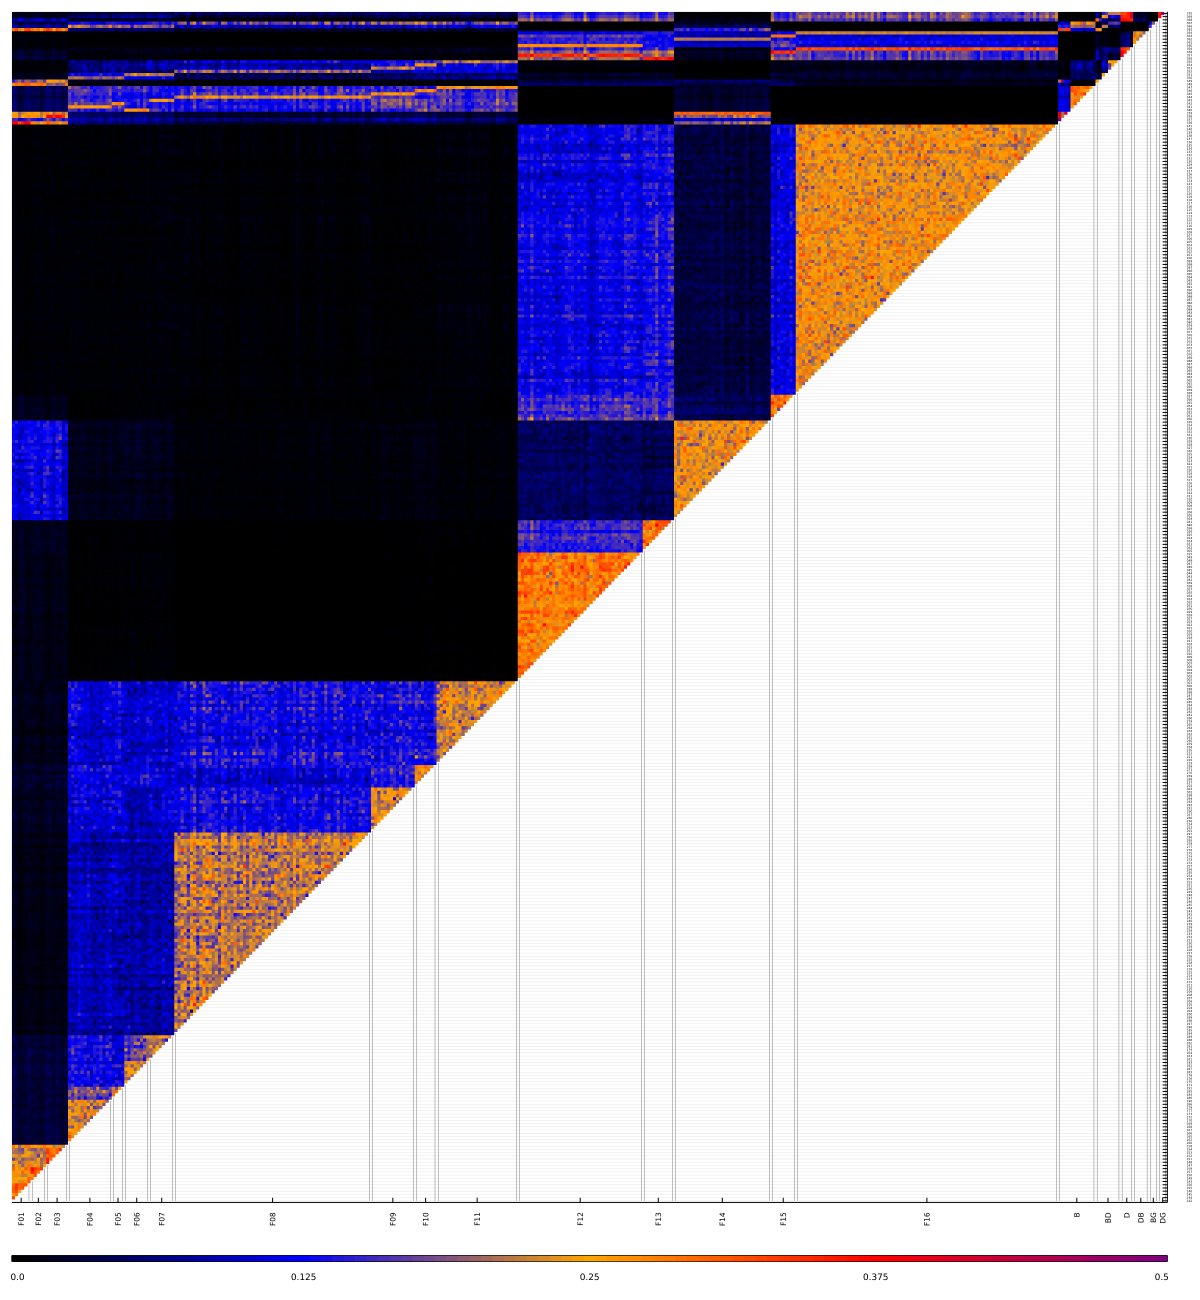

In [188]:
l = @layout [a; b{0.005h}]
fig = plot(size=(1200,1300),layout=l)
color_scheme = cgrad([:black,:blue,:orange,:red,:purple], rev=false)
heatmap!(fig,transpose(K),
    # xticks=(Array(1:size(sampleID)[1]) .+ 0,sampleID),
    yticks=(Array(1:size(sampleID)[1]) .+ 0,sampleID),
    xlabel="",ylabel="",
    ymirror=true,
    color=color_scheme,
    ygrid=:on,
    xgrid=:off,
    xguidefontsize=8,
    # right_margin=0mm,
    yguidefontsize=8,
    xtickfontsize=5,
    ytickfontsize=2,
    xrotation=90,
    # aspect_ratio=1,
    colorbar=false,
    xlims=(0.5,size(sampleID)[1]+0.5),
    ylims=(0.5,size(sampleID)[1]+0.5),
    clims=(-0.0,1/2),
    subplot=1)



heatmap!(fig,reshape(0:0.01:1,1,101),
    xticks=([0,25,50,75,100] .+ 1,[0,0.25,0.5,0.75,1]./2),
    yticks=[],
    xtickfontsize=6,
    label="",
    grid=:off,
    framestyle=:box,
    clims=(-0.0,1.0),
    color=color_scheme,
    colorbar=false,
    subplot=2)

for i in 1:size(family_border_idx)[2]
    
    plot!(fig,[family_border_idx[1,i],family_border_idx[1,i]],[1,family_border_idx[1,i]],
        label="",
        linewidth=0.25,
        color=:black,
        subplot=1)
    plot!(fig,[family_border_idx[2,i],family_border_idx[2,i]],[1,family_border_idx[2,i]],
        label="",
        linewidth=0.25,
        color=:black,
        subplot=1)
    
end

xticks!(fig,
    ((family_border_idx[1,:] .+ family_border_idx[2,:])./2,unique(FamilyID)),
    subplot=1)

fig

In [189]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility"

savefig(fig,string(dir_output,"/Kinship_afterCorrection.pdf"))
savefig(fig,string(dir_output,"/Kinship_afterCorrection.png"))

#### Inbreeding coefficients

In [182]:
chr_list = 1:29
Fa_all = zeros(68265,0)
Fb_all = zeros(68265,0)

sp1 = zeros(68265)
sp2 = zeros(68265)


k = 0

for chr in chr_list
    
    if isfile("Joint.HiC_scaffold_$(chr).snp.filtered2.vcf.gz.res.spill0.res")
        continue
    else

        df = DataFrame(CSV.File("Joint.HiC_scaffold_$(chr).snp.filtered2.vcf.gz.res"))

        if k == 0
            # convert output of ngsrelate's individual indices to my own sample indices
            sp1 = 370 .- df[!,:a]
            sp2 = 370 .- df[!,:b]
        end
        
        k = k+1

        Fa = df[!,:Fa]
        Fb = df[!,:Fb]
        Fa_all = hcat(Fa_all,Fa)
        Fb_all = hcat(Fb_all,Fb)
    end
end

println(k)

Fa_average = dropdims(mean(Fa_all;dims=2),dims=2);
Fb_average = dropdims(mean(Fb_all;dims=2),dims=2);

parents_idx = (sp1 .>= 336) .& (sp2 .>= 336)

Fa_parents = Fa_average[parents_idx]
Fb_parents = Fb_average[parents_idx]
sp1_parents = sp1[parents_idx]
sp2_parents = sp2[parents_idx];

29


595-element Vector{Int64}:
 369
 368
 367
 366
 365
 364
 363
 362
 361
 360
 359
 358
 357
   ⋮
 337
 336
 339
 338
 337
 336
 338
 337
 336
 337
 336
 336

In [183]:
F_all = zeros(370)

for i in 336:370
    F_all[i] = mean(vcat(Fa_parents[sp1_parents .== i],Fb_parents[sp2_parents .== i]))
end

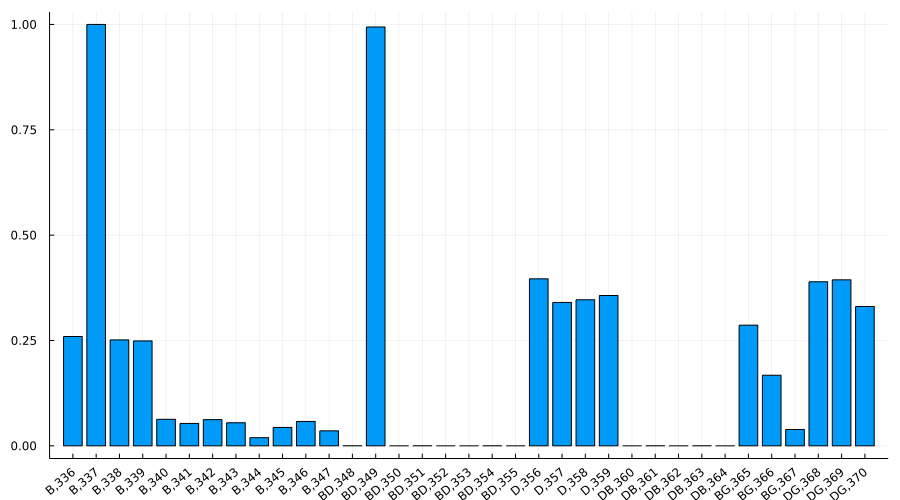

In [185]:
fig = plot(size=(900,500))
idx = 336:370
bar!(fig,idx,F_all[idx],
    xlims=(335,371),
    xticks=(idx,string.(FamilyID[idx],",",sampleID[idx])),
    xrotation=40,
    label="")

# Analysis of inferred ancestry haplotypes

## OrderMarker2 Output

In [2]:
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/05.2_linkageMap.lepmap3"

cd(dir_source)

In [3]:
function get_marker_pos(chr::Int64,dir)
    
    pos = readdlm("$(dir)/call_data/data.call.with_pseudoGrandparents.fixedDiff_only.marker_positions/chr.$(chr).txt",String)
    
    return [parse(Int32,i[1]) for i in split.(pos,"*")][:,1]::Array{Int32,1}
    
end

get_marker_pos (generic function with 1 method)

In [4]:
function get_individual_alleles(x)
    
    Y = Bool[]
    for y in x
        z = split(y," ")[1]::SubString{String}
        z = parse.(Bool,split(z[1:Int(length(z)/2)],""))::BitVector
        Y = vcat(Y,z)
    end
    
    return Y::Vector{Bool}
    
end

get_individual_alleles (generic function with 1 method)

In [5]:
function get_recombination_breakpoints(h)
    
    δh = h[:,2:end] .- h[:,1:end-1]
    
    transitions = δh .!= 0
    
    return [findall(transitions[i,:]) for i in 1:size(transitions)[1]]
    
end

get_recombination_breakpoints (generic function with 1 method)

## Inferring crossover patterns

In [40]:
f_0co_all = []
f_1co_all = []
f_2co_all = []

n_0re_all = []
n_1re_all = []
n_2re_all = []

for chr1 in 1:30

println(chr1)
    
family = "F01-F16"

if family == "F12-F16"
    f_idx = Array(12:16)
elseif family == "F01-F11"
    f_idx = Array(1:11)
else
    f_idx = Array(1:16)
end

marker_skips=2

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx_1 = []
male_cM_1 = []
hap1 = []

open("order_markers_results/$(subdir)/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr1).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx_1,x[1])
            push!(male_cM_1,x[2])
            push!(hap1,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

marker_idx_1 = parse.(Int32,marker_idx_1)
male_cM_1 = parse.(Float32,male_cM_1)
hap1 = hcat(hap1...)
    
hap1 = Float16.(hap1)

GC.gc()

idx = 1:marker_skips:size(hap1)[2]
h1 = hap1[:,idx]
m_cM_1 = male_cM_1[idx]

N=size(h1)[1]

marker_pos_1 = get_marker_pos(chr1,dir_source)

x_pos = marker_pos_1[marker_idx_1[idx]]

breakpoints = get_recombination_breakpoints(h1)
n_recombinations = length.(breakpoints)

if any(n_recombinations .> 2)
    n_toomany = sum(n_recombinations .> 2)
    println("Chr$(chr1): More than 2 recombinations detected in $(n_toomany) samples!!")
end

n0 = sum(n_recombinations .== 0)
n1 = sum(n_recombinations .== 1)
n2 = sum(n_recombinations .== 2)

push!(n_0re_all,n0)
push!(n_1re_all,n1)
push!(n_2re_all,n2)

  
f_0co = (n0-n1+n2)/(n0+n1+n2)
f_1co = 2*(n1-2*n2)/(n0+n1+n2)
f_2co = 4*n2/(n0+n1+n2)
    
if any([f_0co,f_1co,f_2co].<0) & (n2 > 0)
    f_0co = 0
    f_1co = 1-2*n2/(n0+n2)
    f_2co = 2*n2/(n0+n2)
elseif any([f_0co,f_1co,f_2co].<0) & (n2==0)
    f_0co = max(0,(n0-n1)/(n0+n1))
    f_1co = min(1,2*n1/(n0+n1))
    f_2co = 0
end

if chr1==14
    push!(f_0co_all,NaN)
    push!(f_1co_all,NaN)
    push!(f_2co_all,NaN)
else 
    push!(f_0co_all,f_0co)
    push!(f_1co_all,f_1co)
    push!(f_2co_all,f_2co)
end

end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
Chr14: More than 2 recombinations detected in 1 samples!!
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


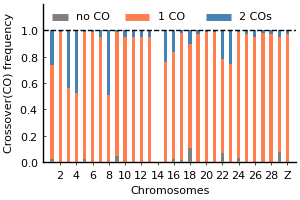

In [38]:
fig = plot(size=(300,200))

x = 1:30

dx = 0.4
bar!(fig,x,f_0co_all .+ f_1co_all .+ f_2co_all,
    xticks=(Array(2:2:30),vcat(string.(Array(2:2:28)),["Z"])),
    xlims=(-Inf,+Inf),
    grid=:off,
    bar_position = :stack,
    color=:steelblue,
    bar_width=0.4,
    linewidth=0,
    label="",
    xlabel="Chromosomes",
    ylabel="Crossover(CO) frequency",
    xguidefontsize=8,
    yguidefontsize=8,
    legend_background_color=false,
    legend=:topleft,
    # legend_column=3,
    xtick_direction=:out,
    yticks=0:0.2:1,
    ylims=(0,1.2),
)

bar!(fig,x,f_0co_all .+ f_1co_all,
    bar_width=0.4,
    linewidth=0,
    color=:coral,
    label="",
    )

bar!(fig,x,f_0co_all,
    bar_width=0.4,
    linewidth=0,
    color=:gray,
    label="",
    )

annotate!(fig,[(4,1.1,Plots.text("no CO",8,:left))])
annotate!(fig,[(14,1.1,Plots.text("1 CO",8,:left))])
annotate!(fig,[(24,1.1,Plots.text("2 COs",8,:left))])

plot!(fig,[1,3],[1.1,1.1],color=:gray,linewidth=5,label="")
plot!(fig,[10,13],[1.1,1.1],color=:coral,linewidth=5,label="")
plot!(fig,[20,23],[1.1,1.1],color=:steelblue,linewidth=5,label="")

hline!(fig,[1],linewidth=1,linestyle=:dash,label="",linecolor=:black)

In [39]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/RefGenomeV3_InferredHaps_LinkageMaps"

savefig(fig,string(dir_output,"/CO_frequency.png"))
savefig(fig,string(dir_output,"/CO_frequency.pdf"))

#### Frequency of double COs versus chromosome size

In [ ]:
chr_size = readdlm("/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/06_polished.genome/chr_size.txt")


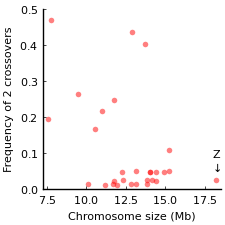

In [27]:
fig = plot(size=(225,225))
scatter!(fig,chr_size[vcat(1:13,15:30)]./1E6,f_2co_all[vcat(1:13,15:30)],
    xlabel="Chromosome size (Mb)",
    ylabel="Frequency of 2 crossovers",
    xguidefontsize=8,
    yguidefontsize=8,
    grid=:off,
    label="",
    markerstrokewidth=0,
    markeralpha=0.5,
    markercolor=:red,
    ylims=(0,0.5),
)

annotate!(fig,[(chr_size[end]/1E6,0.075,Plots.text(string("Z\n",L"\downarrow"),8))])

In [28]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/RefGenomeV3_InferredHaps_LinkageMaps"

savefig(fig,string(dir_output,"/DoubleCO_freq.png"))
savefig(fig,string(dir_output,"/DoubleCO_freq.pdf"))

#### Z chromosome recombination breakpoints distribution

In [30]:
chr1=30

family = "F01-F16"

if family == "F12-F16"
    f_idx = Array(12:16)
elseif family == "F01-F11"
    f_idx = Array(1:11)
else
    f_idx = Array(1:16)
end

marker_skips=1

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx_1 = []
male_cM_1 = []
hap1 = []

open("order_markers_results/$(subdir)/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr1).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx_1,x[1])
            push!(male_cM_1,x[2])
            push!(hap1,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

marker_idx_1 = parse.(Int32,marker_idx_1)
male_cM_1 = parse.(Float32,male_cM_1)
hap1 = hcat(hap1...)
    
hap1 = Float16.(hap1)

GC.gc()

idx = 1:marker_skips:size(hap1)[2]
h1 = hap1[:,idx]
m_cM_1 = male_cM_1[idx]

N=size(h1)[1]

marker_pos_1 = get_marker_pos(chr1,dir_source)

x_pos = marker_pos_1[marker_idx_1[idx]]

breakpoints = get_recombination_breakpoints(h1)
n_recombinations = length.(breakpoints);

In [31]:
breakpoints_1recomb = x_pos[vcat(breakpoints[n_recombinations .== 1]...)]
breakpoints_2recomb = x_pos[vcat(breakpoints[n_recombinations .== 2]...)]

4-element Vector{Int32}:
  1959766
 16043567
  5995329
  9039957

In [32]:
using KernelDensity
using HypothesisTests
using Distributions
using LaTeXStrings

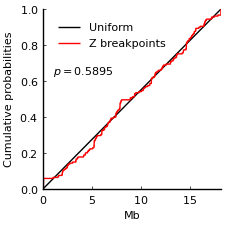

In [35]:
x = 0:1E3:x_pos[end]

cdf = [sum(breakpoints_1recomb .<= i)/length(breakpoints_1recomb) for i in x]

fig = plot(size=(225,225))

plot!(fig,[x[1],x[end]]./1E6,[0,1],
    label="Uniform",
    linewidth=1,
    linecolor=:black,
    linealpha=1,
    grid=:off,
    legend_background_color=false,
    legend=:topleft,
    xlims=(0,+Inf),
    ylims=(0,1),
)
plot!(fig,x./1E6,cdf,
    label="Z breakpoints",
    linecolor=:red,
    linewidth=1,
    xlabel="Mb",
    ylabel="Cumulative probabilities",
    xguidefontsize=8,
    yguidefontsize=8,
)
annotate!(fig,[(1,0.65,Plots.text(L"p=0.5895",8,:left))])



In [307]:
ExactOneSampleKSTest(vcat(breakpoints_1recomb),
    Uniform(0,1*x_pos[end]))

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /n/home00/txiong/.julia/packages/HypothesisTests/ED0fC/src/kolmogorov_smirnov.jl:68


Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0573114

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.5895

Details:
    number of observations:   176


In [36]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/RefGenomeV3_InferredHaps_LinkageMaps"

savefig(fig,string(dir_output,"/Z_breakpoints_CDF.png"))
savefig(fig,string(dir_output,"/Z_breakpoints_CDF.pdf"))


#### Plot phased haplotypes (phase = grandparental phase, not species ancestry)

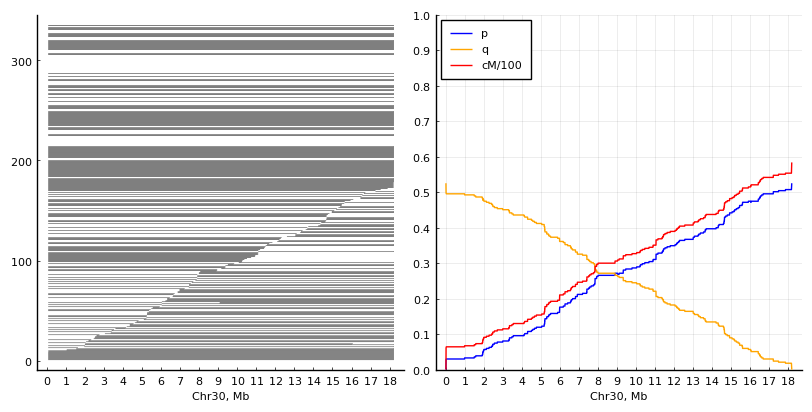

In [14]:
# function plot_haplotypes(chr1::Int64,dir_source,get_individual_alleles::Function,get_marker_pos::Function;marker_skips=100)

for chr1 in 30:30

family = "F01-F16"

if family == "F12-F16"
    f_idx = Array(12:16)
elseif family == "F01-F11"
    f_idx = Array(1:11)
else
    f_idx = Array(1:16)
end

marker_skips=2

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx_1 = []
male_cM_1 = []
hap1 = []

open("order_markers_results/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr1).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx_1,x[1])
            push!(male_cM_1,x[2])
            push!(hap1,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

marker_idx_1 = parse.(Int32,marker_idx_1)
male_cM_1 = parse.(Float32,male_cM_1)
hap1 = hcat(hap1...)
    
hap1 = Float16.(hap1)

GC.gc()

idx = 1:marker_skips:size(hap1)[2]
h1 = hap1[:,idx]
m_cM_1 = male_cM_1[idx]

N=size(h1)[1]

marker_pos_1 = get_marker_pos(chr1,dir_source)

x_pos = marker_pos_1[marker_idx_1[idx]];

## remove below if necessary

firstswitch=[]
secondswitch=[]

for i in 1:N
    h = h1[i,:] 
    δ = h[2:end] .- h[1:end-1]
    t = findall(δ .!= 0)
    if length(t) == 0 
        append!(firstswitch,NaN)
        append!(secondswitch,NaN)
    elseif length(t) == 1
        append!(firstswitch,t[1])
        append!(secondswitch,NaN)
    elseif length(t) == 2
        append!(firstswitch,t[1])
        append!(secondswitch,t[2])
    end
end

perm_order = sortperm(firstswitch);

recomb_p = []
recomb_q = []
recomb_double = []
for i in 1:size(h1)[2]
    append!(recomb_p,1 - sum(h1[:,1] .=== h1[:,i])/N)
    append!(recomb_q,1 - sum(h1[:,end] .=== h1[:,i])/N)
    append!(recomb_double,sum((h1[:,1] .!= h1[:,i]) .& (h1[:,end] .!= h1[:,i]))/N)
end
interference = recomb_p .* recomb_q - recomb_double;

fig = plot(size=(800,400),layout=(1,2))
for i in Array(1:size(perm_order)[1])
    plot!(fig,x_pos ./10^6,h1[perm_order[i],:]./2 .+ i,label="",
        seriestype=:steppre,
        linecolor=:white,
        fillcolor=:black,
        xticks=0:1:(x_pos[end]/10^6),
        xlabel="Chr$(chr1), Mb",
        xguidefontsize=8,
        format=:png,
        grid=:off,
        fillrange=i,
        subplot=1)
end
plot!(fig,x_pos ./10^6,recomb_p,
    ylims=(0,1),label="p",
    legend=:topleft,
    color=:blue,
    yticks=0:0.1:1,
    xlabel="Chr$(chr1), Mb",
    xguidefontsize=8,
    xticks=0:1:(x_pos[end]/10^6),
    subplot=2)
plot!(fig,x_pos ./10^6,recomb_q,
    ylims=(0,1),label="q",
    legend=:topleft,
    color=:orange,
    yticks=0:0.1:1,
    xticks=0:1:(x_pos[end]/10^6),
    subplot=2)
# plot!(fig,x_pos ./10^6,interference,
#     ylims=(0,1),label="IF",
#     legend=:topleft,
#     color=:green,
#     yticks=0:0.1:1,
#     xticks=0:1:(x_pos[end]/10^6),
#     subplot=2)
# plot!(fig,x_pos ./10^6,mean(h1;dims=1)[1,:],
#     ylims=(0,1),label="mean ancestry",
#     legend=:topleft,
#     color=:black,
#     yticks=0:0.1:1,
#     xticks=0:1:(x_pos[end]/10^6),
#     subplot=2)
plot!(fig,x_pos ./10^6,m_cM_1./100,
    ylims=(0,1),label="cM/100",
    color=:red,
    subplot=2)
# scatter!(fig,x_pos ./10^6,[0.5],
#     marker=:vline,
#     markersize=2,
#     ylims=(0,1),label="",
#     yticks=0:0.1:1,
#     subplot=2)

dir_output = "/n/home00/txiong/Research/2022_HybridSterility/RefGenomeV3_InferredHaps_LinkageMaps"

savefig(fig,string(dir_output,"/chr$(chr1).png"))
    

end

#### Converting phased outputs to species ancestry

In [27]:
for chr in 2:30

family = "F01-F16"

if family == "F12-F16"
    f_idx = Array(12:16)
elseif family == "F01-F11"
    f_idx = Array(1:11)
else
    f_idx = Array(1:16)
end

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx = []
male_cM = []
hap = []

open("order_markers_results/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx,x[1])
            push!(male_cM,x[2])
            push!(hap,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

marker_idx = parse.(Int32,marker_idx)
male_cM = parse.(Float32,male_cM)
hap = Int8.(hcat(hap...))

# bianor: 0; dehaanii: 1

ancestry = vcat(1 .- hap[1:162,:],hap[163:335,:])

dir_out = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/05.2_linkageMap.lepmap3/order_markers_results"
file_name = "/ancestry.paternal.B0D1.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.0.001.$(family).chr.$(chr).txt"
open(string(dir_out,file_name),"w") do file
    for i in 1:335
        write(file,string(join(string.(ancestry[i,:])," "),"\n"))
    end
end
    
end

#### Recombination between HiC scaffolds

In [3]:
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/05.1_linkageMap.lepmap3"

cd(dir_source)

In [7]:
chr1=1 # use one marker from chr1

family = "F01-F11"

if family == "F12-F16"
    f_idx = Array(12:16)
else
    f_idx = Array(1:11)
end

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx_1 = []
male_cM_1 = []
phased_gt_1 = [] 
open("order_markers_results/$(subdir)/impute.with_pseudoGrandparents.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr1).txt","r") do io
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx_1,x[1])
            push!(male_cM_1,x[2])
            push!(phased_gt_1,x[f_idx .+ 4])
        end
    end
end

k=1

fig = plot(size=(800,1000),layout=(6,5))

# against all markers from chr2
for chr2 in Array(4:4)[Array(4:4) .!= chr1]
    
    println(chr2)
    
    interference = "0.001"
    subdir = "impute.with_pseudoGrandparents.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

    marker_idx_2 = []
    male_cM_2 = []
    phased_gt_2 = [] 
    open("order_markers_results/$(subdir)/impute.with_pseudoGrandparents.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr2).txt","r") do io
        for l in eachline(io)
            if string(l[1]) != "#"
                x = split(l,"\t")
                push!(marker_idx_2,x[1])
                push!(male_cM_2,x[2])
                push!(phased_gt_2,x[f_idx .+ 4])
            end
        end
    end
    
    Y=""
    chr1_idx = 1 # use this marker from chr1
    for y in phased_gt_1[chr1_idx]
        z = split(y," ")[1]
        Y = string(Y,z[1:Int(length(z)/2)])
    end
    hap1 = parse.(Int,split(Y,""))

    p = [] # recombination prob.
    r2 = [] # squared correlation coefficient

    @showprogress 1 for i in 1:size(phased_gt_2)[1]

        x = phased_gt_2[i]
        Y=""
        for y in x
            z = split(y," ")[1]
            Y = string(Y,z[1:Int(length(z)/2)])
        end

        Y = parse.(Int,split(Y,""))
        
        N = size(Y)[1]

        t = hap1 .=== Y
        
        D2 = (sum(hap1 .* Y)/N - sum(hap1)/N * sum(Y)/N)^2

        push!(p,1 - sum(t) ./ N)
        push!(r2,D2/(sum(hap1)/N*(1-sum(hap1)/N)*sum(Y)/N*(1-sum(Y)/N)))
        

    end
    
    plot!(fig,(1:size(p)[1])./10^5,r2,label="",
    title=string("Chr$(chr1):$(chr1_idx) to $(chr2),",family),
    titlefontsize=8,
    xlims=(0,+Inf),
    ylims=(0,1),
    subplot=k)
    
    k=k+1
    
end

4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


In [138]:
dir_output="/n/home00/txiong/Research/2022_HybridSterility/RefGenome_RecombinationBetweenChrs"

prefix="/chr.$(chr1).marker.1.families.$(family)"

savefig(fig,string(dir_output,prefix,".png"))
savefig(fig,string(dir_output,prefix,".pdf"))

#### Compare the pairwise association of all markers from one HiC scaffold to all markers to another HiC scaffold

In [1]:
using Plots; pyplot()
using Plots.Measures
using DelimitedFiles, DataFrames, CSV, JLD
using StatsBase    
using Combinatorics
using ProgressMeter


In [2]:
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/05.1_linkageMap.lepmap3"

cd(dir_source)

In [3]:
function get_marker_pos(chr::Int64,dir)
    
    pos = readdlm("$(dir)/call_data/data.call.with_pseudoGrandparents.marker_positions/chr.$(chr).txt",String)
    
    return [parse(Int32,i[1]) for i in split.(pos,"*")][:,1]::Array{Int32,1}
    
end

get_marker_pos (generic function with 1 method)

In [4]:
function get_individual_alleles(x)
    
    Y = Bool[]
    for y in x
        z = split(y," ")[1]::SubString{String}
        z = parse.(Bool,split(z[1:Int(length(z)/2)],""))::BitVector
        Y = vcat(Y,z)
    end
    
    return Y::Vector{Bool}
    
end

get_individual_alleles (generic function with 1 method)

In [14]:
function produce_figures(chr1::Int64,chr2::Int64,dir_source,get_individual_alleles::Function,get_marker_pos::Function;marker_skips=100)

# chr1=4
# chr2=4

family = "F01-F16"

if family == "F12-F16"
    f_idx = Array(12:16)
elseif family == "F01-F11"
    f_idx = Array(1:11)
else
    f_idx = Array(1:16)
end

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx_1 = []
# male_cM_1 = []
hap1 = []

open("order_markers_results/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr1).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx_1,x[1])
            # push!(male_cM_1,x[2])
            push!(hap1,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

marker_idx_1 = parse.(Int32,marker_idx_1)
hap1 = hcat(hap1...)
    

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx_2 = []
# male_cM_2 = []
hap2 = []

open("order_markers_results/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr2).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx_2,x[1])
            # push!(male_cM_2,x[2])
            push!(hap2,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

marker_idx_2 = parse.(Int32,marker_idx_2)
hap2 = hcat(hap2...)

hap1 = Float16.(hap1)
hap2 = Float16.(hap2)
GC.gc()

idx = 1:marker_skips:size(hap1)[2]
idy = 1:marker_skips:size(hap2)[2]
h1 = hap1[:,idx]
h2 = hap2[:,idy]

N=size(h1)[1]
    
p1 = sum(h1,dims=1) ./ N
p2 = sum(h2,dims=1) ./ N
r2 = ((transpose(h2) * h1 ./ N .- transpose(p2) * p1).^2) ./ (transpose(p2 .* (1 .- p2)) * (p1 .* (1 .- p1)));

marker_pos_1 = get_marker_pos(chr1,dir_source)
marker_pos_2 = get_marker_pos(chr2,dir_source)

x_pos = marker_pos_1[marker_idx_1[idx]]
y_pos = marker_pos_2[marker_idx_2[idy]]

fig=plot(size=(600,600))
heatmap!(fig,x_pos./10^6,y_pos./10^6,r2,
    clims=(0,1),
    xlabel="Chr$(chr1),Mb",
    ylabel="Chr$(chr2),Mb",
    guidefontsize=10,
    xlims=(0,+Inf),
    ylims=(0,+Inf),
    grid=:off,
    aspect_ratio=1,
    fmt = :png,
    color=:gist_stern);

# dir_output = "/n/home00/txiong/Research/2022_HybridSterility/RefGenome_RecombinationBetweenChrs"

# savefig(fig,string(dir_output,"/chr$(chr1).vs.chr$(chr2).family.$(family).png"))
    
    return fig

end


produce_figures (generic function with 1 method)

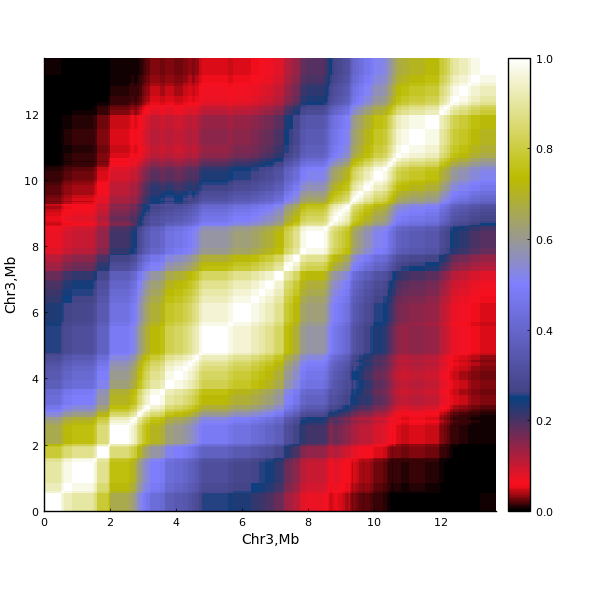

In [10]:
chr = 3
produce_figures(chr,chr,dir_source,get_individual_alleles,get_marker_pos;marker_skips=100)



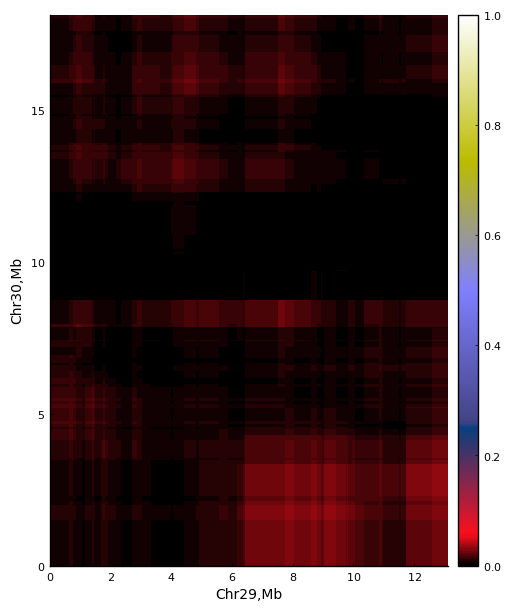

1,30
2,30
3,30
4,30
5,30
6,30
7,30
8,30
9,30
10,30
11,30
12,30
13,30
14,30
15,30
16,30
17,30
18,30
19,30
20,30
21,30
22,30
23,30
24,30
25,30
26,30
27,30
28,30
29,30


In [18]:
for i in 1:29
    for j in 30:30
        println("$i,$j")
        produce_figures(i,j,dir_source,get_individual_alleles,get_marker_pos;marker_skips=50)
        GC.gc()
    end
end

#### Generate detailed association maps in a specific region

In [4]:
function show_markers_association(hap01,hap02;marker_skips=100,figtype="")
    
    idx = 1:marker_skips:size(hap01)[2]
    idy = 1:marker_skips:size(hap02)[2]
    h1 = hap01[:,idx]
    h2 = hap02[:,idy]
    
    N=size(h1)[1]
    
    p1 = sum(h1,dims=1) ./ N
    p2 = sum(h2,dims=1) ./ N
    r2 = ((transpose(h2) * h1 ./ N .- transpose(p2) * p1).^2) ./ (transpose(p2 .* (1 .- p2)) * (p1 .* (1 .- p1)));
    
    fig=plot(size=(600,600))
    
    if figtype=="contour"
        contour!(fig,r2,
            clims=(0,1),
            xlabel="Chr$(chr1),Mb",
            ylabel="Chr$(chr2),Mb",
            guidefontsize=10,
            # xlims=(0,+Inf),
            # ylims=(0,+Inf),
            grid=:off,
            aspect_ratio=1,
            fill=true,
            # level=100,
            fmt = :png,
            color=:gist_stern);
        
    else
        heatmap!(fig,r2,
            clims=(0,1),
            xlabel="Chr$(chr1),Mb",
            ylabel="Chr$(chr2),Mb",
            guidefontsize=10,
            # xlims=(0,+Inf),
            # ylims=(0,+Inf),
            grid=:off,
            aspect_ratio=1,
            fmt = :png,
            # color=:jet,
            color=:gist_stern,
            # color=:inferno,
            );
    end
    
end

show_markers_association (generic function with 1 method)

In [5]:
## get gap positions
function get_gap_position(chr)
    
    dir_source_gaps = "/n/holyscratch01/mallet_lab/txiong/Research/2019_Achillides_Sequencing/00_genome_Pbianor"
    lines = readdlm("$(dir_source_gaps)/Pb.fa.gaps.bed")
    lines[:,1] = [parse(Int,split(lines[i,1],"_")[end]) for i in 1:size(lines)[1]];

    # chr_size = readdlm("/n/boslfs02/LABS/mallet_lab/Lab/txiong/Research/2019_Achillides_Sequencing/00_genome_Pbianor/Pb.chr_size.list")
    # chr_size = Int.(chr_size[1:30,1]);
    
    idx = lines[:,1] .== chr
    gap_mid_pos = (lines[idx,3] .+ lines[idx,2])./2
    
    return gap_mid_pos
    
end

get_gap_position (generic function with 1 method)

In [18]:
chr1=4
chr2=4

family = "F01-F11"

if family == "F12-F16"
    f_idx = Array(12:16)
else
    f_idx = Array(1:11)
end

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx_1 = []
# male_cM_1 = []
hap1 = []

open("order_markers_results/impute.with_pseudoGrandparents.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr1).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx_1,x[1])
            # push!(male_cM_1,x[2])
            push!(hap1,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

marker_idx_1 = parse.(Int32,marker_idx_1)
hap1 = hcat(hap1...)
    

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx_2 = []
# male_cM_2 = []
hap2 = []

open("order_markers_results/impute.with_pseudoGrandparents.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr2).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx_2,x[1])
            # push!(male_cM_2,x[2])
            push!(hap2,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

marker_idx_2 = parse.(Int32,marker_idx_2)
hap2 = hcat(hap2...)

hap1 = Float16.(hap1)
hap2 = Float16.(hap2)
GC.gc()

# marker_pos_1 = get_marker_pos(chr1,dir_source)[marker_idx_1]
# marker_pos_2 = get_marker_pos(chr2,dir_source)[marker_idx_2];

# gap_pos = get_gap_position(chr1);


In [202]:
x=0
test1 = (marker_pos_1 .>=(5.4E6+x)) .& (marker_pos_1  .<=(5.7E6+x))
test2 = (marker_pos_2 .>=(5.4E6+x)) .& (marker_pos_2  .<=(5.7E6+x))

println([sum(test1),sum(test2)])

[5108, 5108]


In [203]:
h1 = hap1[:,test1]
h2 = hap2[:,test2]

N=size(h1)[1]
    
p1 = sum(h1,dims=1) ./ N
p2 = sum(h2,dims=1) ./ N
r2 = ((transpose(h2) * h1 ./ N .- transpose(p2) * p1).^2) ./ (transpose(p2 .* (1 .- p2)) * (p1 .* (1 .- p1)));


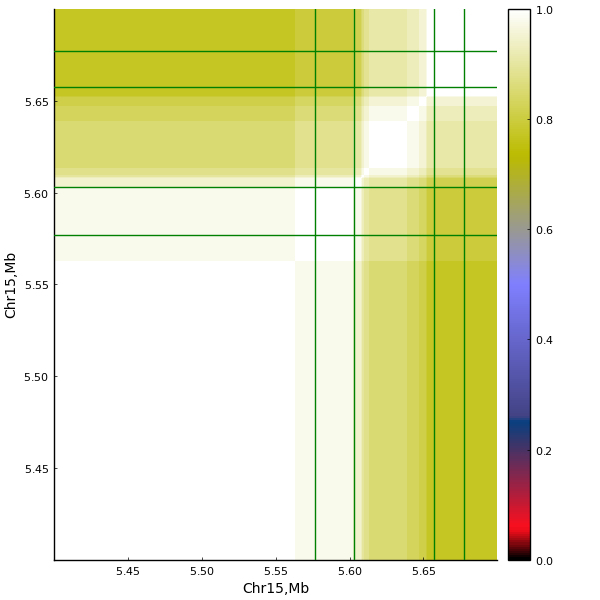

In [204]:
x_pos = marker_pos_1[test1]
y_pos = marker_pos_2[test2]

fig=plot(size=(600,600))
heatmap!(fig,x_pos./10^6,y_pos./10^6,r2,
    clims=(0,1),
    xlims=(x_pos[1]/10^6,x_pos[end]/10^6),
    ylims=(y_pos[1]/10^6,y_pos[end]/10^6),
    xlabel="Chr$(chr1),Mb",
    ylabel="Chr$(chr2),Mb",
    # xticks=x_pos./10^6,
    # yticks=y_pos./10^6,
    guidefontsize=10,
    grid=:off,
    # aspect_ratio=1,
    fmt = :png,
    color=:gist_stern)


for i in gap_pos
    hline!(fig,[i]./10^6,
        linecolor=:green,
        label="")
    vline!(fig,[i]./10^6,
        linecolor=:green,
        label="")
end


fig

#### testing different ways to correct assembly errors in each HiC scaffold

In [205]:
pointers_1 = marker_pos_1 .<= 3737808
pointers_2 = (marker_pos_1 .>= 3737808) .& (marker_pos_1 .<= 3790779)
# pointers_2 = (marker_pos_1 .>= 3134393) .& (marker_pos_1 .<= 4511792)
pointers_3 = (marker_pos_1 .>= 3790779) .& (marker_pos_1 .<= 5603287)
pointers_4 = (marker_pos_1 .>= 5603287)

old_order = Array(1:length(marker_pos_1))
new_order = vcat(reverse(old_order[pointers_1]),(old_order[pointers_4]),reverse(old_order[pointers_3]),(old_order[pointers_2]))
hap1_1 = hap1[:,new_order]
hap2_1 = hap2[:,new_order];

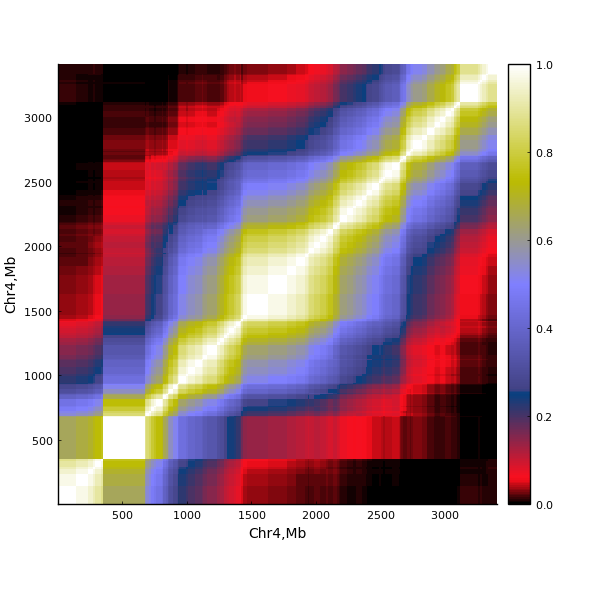

In [19]:
show_markers_association(hap1,hap2,;marker_skips=100,figtype="")

## Results of generating new marker orders from LepMap3

In [2]:
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/05.2_linkageMap.lepmap3"

cd(dir_source)

In [3]:
function get_marker_pos(chr::Int64,dir)
    
    pos = readdlm("$(dir)/call_data/data.call.with_pseudoGrandparents.fixedDiff_only.marker_positions/chr.$(chr).txt",String)
    
    return [parse(Int32,i[1]) for i in split.(pos,"*")][:,1]::Array{Int32,1}
    
end

# function get_gap_position(chr)
    
#     dir_source_gaps = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/06_polished.genome"
#     lines = readdlm("$(dir_source_gaps)/Pb_new.fa.gaps.bed")
#     lines[:,1] = [parse(Int,split(lines[i,1],"_")[end]) for i in 1:size(lines)[1]];

#     chr_size = readdlm("/n/boslfs02/LABS/mallet_lab/Lab/txiong/Research/2019_Achillides_Sequencing/00_genome_Pbianor/Pb.chr_size.list")
#     chr_size = Int.(chr_size[1:30,1]);
    
#     idx = lines[:,1] .== chr
#     gap_left_pos = lines[idx,2].+1
#     gap_right_pos = lines[idx,3]
    
#     return gap_left_pos,gap_right_pos
    
# end

In [189]:
chr = 28

lines = readdlm("order_markers_results/improve.1.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.0.001.F01-F16.chr.$(chr).txt")
order = lines[4:end,1];

pos = get_marker_pos(chr,dir_source)[sort(order)]./10^6
# gaps_l,gaps_r = get_gap_position(chr);


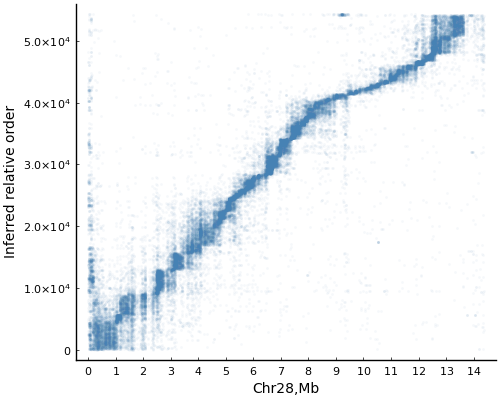

In [190]:
fig = plot(size=(500,400))
# vline!(fig,(gaps_l .+ gaps_r) ./2 ./10^6,linealpha=0.25,linewidth=0.5,label="",color=:black)

scatter!(fig,pos,(order),
    label="",
    markeralpha=0.05,
    markersize=2,
    # ylims=(0,+Inf),
    xlabel="Chr$(chr),Mb",
    xticks=Array(0:1:maximum(pos)),
    xguidefontsize=10,
    ylabel="Inferred relative order",
    markercolor=:steelblue,
    xrotation=90,
    grid=:off,
    yguidefontsize=10,
    # aspect_ratio=1,
    markerstrokewidth=0)


In [191]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/RefGenomeV3_ReorderMarkers"

savefig(fig,string(dir_output,"/chr.$(chr).reorder_once.png"))

#### Visualize gaps (NNNs) in the fasta Pb.fa reference genome

In [39]:
function get_gap_position(chr)
    
    dir_source_gaps = "/n/holyscratch01/mallet_lab/txiong/Research/2019_Achillides_Sequencing/00_genome_Pbianor"
    lines = readdlm("$(dir_source_gaps)/Pb.fa.gaps.bed")
    lines[:,1] = [parse(Int,split(lines[i,1],"_")[end]) for i in 1:size(lines)[1]];

    chr_size = readdlm("/n/boslfs02/LABS/mallet_lab/Lab/txiong/Research/2019_Achillides_Sequencing/00_genome_Pbianor/Pb.chr_size.list")
    chr_size = Int.(chr_size[1:30,1]);
    
    idx = lines[:,1] .== chr
    gap_mid_pos = (lines[idx,3] .+ lines[idx,2])./2
    
    return gap_mid_pos
    
end


get_gap_position (generic function with 1 method)

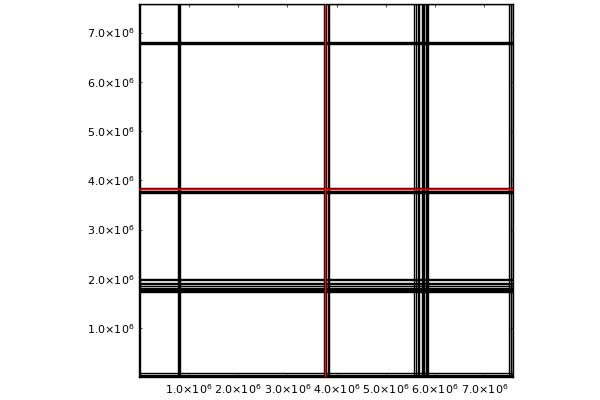

In [37]:

fig = plot()

for i in gap_mid_pos
    plot!(fig,[i,i],[1,chr_size[chr]],
        linecolor=:black,
        xlims=(1,chr_size[chr]),
        ylims=(1,chr_size[chr]),
        aspect_ratio=1,
        grid=:off,
        framestyle=:box,
        label="")
    plot!(fig,[1,chr_size[chr]],chr_size[chr] .- [i,i],
        linecolor=:black,
        label="")
end

for i in [3762841,3763543]
    plot!(fig,[i,i],[1,chr_size[chr]],
        linecolor=:red,
        xlims=(1,chr_size[chr]),
        ylims=(1,chr_size[chr]),
        aspect_ratio=1,
        grid=:off,
        framestyle=:box,
        label="")
    plot!(fig,[1,chr_size[chr]],chr_size[chr] .- [i,i],
        linecolor=:red,
        label="")
end

fig

In [ ]:
chr = 30

dir_source_gaps = "/n/holyscratch01/mallet_lab/txiong/Research/2019_Achillides_Sequencing/00_genome_Pbianor"
lines = readdlm("$(dir_source_gaps)/Pb.fa.gaps.bed")
lines[:,1] = [parse(Int,split(lines[i,1],"_")[end]) for i in 1:size(lines)[1]]

idx = lines[:,1] .== chr
gap_mid_pos = string.((lines[idx,3] .+ lines[idx,2])./2)

gap_left = string.(lines[idx,2] .+ 1)

gap_right = string.(lines[idx,3])

print(join([join([gap_mid_pos[i],gap_left[i],gap_right[i]],"\t") for i in 1:size(gap_left)[1]],"\n"))
    

# Generating pseudograndparents for families with missing grandparents

#### Grab fixed differences between grandparents

In [2]:
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/03.2_call.bcftools/vcfs"

cd(dir_source)

In [ ]:
for chr in 1:30
    
println(chr)

# autosomal pattern
gt_1 = vcat(repeat(["0/0"],3),repeat(["1/1"],3))
gt_2 = vcat(repeat(["0/0"],3),repeat(["2/2"],3))
gt_3 = vcat(repeat(["1/1"],3),repeat(["0/0"],3))
gt_4 = vcat(repeat(["2/2"],3),repeat(["0/0"],3))
gt_5 = vcat(repeat(["1/1"],3),repeat(["2/2"],3))
gt_6 = vcat(repeat(["2/2"],3),repeat(["1/1"],3))
    
# z chromosome pattern, female grandparents are the first three samples, male grandparents are the rest
# gt_1 = vcat(repeat(["0"],3),repeat(["1/1"],3))
# gt_2 = vcat(repeat(["0"],3),repeat(["2/2"],3))
# gt_3 = vcat(repeat(["1"],3),repeat(["0/0"],3))
# gt_4 = vcat(repeat(["2"],3),repeat(["0/0"],3))
# gt_5 = vcat(repeat(["1"],3),repeat(["2/2"],3))
# gt_6 = vcat(repeat(["2"],3),repeat(["1/1"],3))

pos=[]

open(`zcat Joint.HiC_scaffold_$(chr).snp.filtered1.simple_annotation.grandparents.vcf.gz`) do io
    
    for l in eachline(io)
        if string(l[1]) != "#"
            data = split(l,"\t")
            gt = []
            for i in split.(data[end-5:end],":")
                push!(gt,i[1])
            end
            if (gt==gt_1)|(gt==gt_2)|(gt==gt_3)|(gt==gt_4)|(gt==gt_5)|(gt==gt_6)
                push!(pos,data[2])
            end
        end
    end

end

open("Joint.HiC_scaffold_$(chr).snp.filtered1.simple_annotation.grandparents.fixedDiff_withoutRef.chr_pos.txt","w") do file
    for i in 1:size(pos)[1]
        write(file,string("HiC_scaffold_$(chr)","\t",pos[i],"\n"))
    end
end
    
end

#### Make pseudoparents vcf files

In [ ]:
for chr in 1:30
    
println(chr)

header = []
title = []
body = []

open(`zcat Joint.HiC_scaffold_$(chr).snp.filtered1.simple_annotation.grandparents.fixedDiff_withoutRef.vcf.gz`) do io
    
    for l in eachline(io)
        
        if string(l[1:2]) == "##"
            push!(header,l)
        elseif string(l[1:2]) == "#C"
            push!(title,l)
        else
            push!(body,l)
        end      
    end      
end

body = split.(body,"\t")

body_output = []

for j in 1:size(body)[1]
    
    # println(j)
    
    l = body[j]
    
    gt = l[end-5:end]
    gt = split.(gt,":")
    
    gt_B = gt[1][1]
    gt_D = gt[end][1]

    K_B = size(split(gt[1][2],","))[1]
    K_D = size(split(gt[end][2],","))[1]
    PL_B = repeat([0],K_B)
    PL_D = repeat([0],K_D)
    for i in 1:3
        s = split(gt[i][2],",")
        PL_B = PL_B .+ parse.(Int64,s)
    end
    for i in 4:6
        s = split(gt[i][2],",")
        PL_D = PL_D .+ parse.(Int64,s)
    end

    PL_B = Int64.(floor.(PL_B ./3))
    PL_D = Int64.(floor.(PL_D ./3))
    
    output_B = string(gt_B,":",join(string.(PL_B),","))
    output_D = string(gt_D,":",join(string.(PL_D),","))
    
    output = string(join(l[1:end-6],"\t"),"\t",output_D,"\t",output_B)
    
    push!(body_output,output)

end

title_new = [join(vcat(split(title[1],"\t")[1:9],["DP01_SP01","BP01_SP02"]),"\t")]

full_output = vcat(header,title_new,body_output)

open("Joint.HiC_scaffold_$(chr).snp.filtered1.simple_annotation.pseudograndparents.fixedDiff_withRef.vcf","w") do file
    write(file,join(full_output,"\n"))
end
    
end

# Visualize ancestry haplotypes 

In [2]:
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/05.2_linkageMap.lepmap3"


"/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/05.2_linkageMap.lepmap3"

In [3]:
function get_marker_pos(chr::Int64,dir)
    
    pos = readdlm("$(dir)/call_data/data.call.with_pseudoGrandparents.fixedDiff_only.marker_positions/chr.$(chr).txt",String)
    
    return [parse(Int32,i[1]) for i in split.(pos,"*")][:,1]::Array{Int32,1}
    
end

get_marker_pos (generic function with 1 method)

In [4]:
idx_materbalB = vcat(Array(1:162),Array(213:243)) # individual indices for BC with bianor maternal genotype
idx_materbalD = vcat(Array(163:212),Array(244:335)); # individual indices for BC with dehaanii maternal genotype


In [5]:
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/05.2_linkageMap.lepmap3"
dir_geno_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/05.2_linkageMap.lepmap3/order_markers_results"


chr = 30
geno_file = "ancestry.B0D1.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.0.001.F01-F16.chr.$(chr).txt"
geno = readdlm(string(dir_geno_source,"/",geno_file))
geno_matB = geno[idx_materbalB,:]
geno_matD = geno[idx_materbalD,:];


In [6]:
pheno = DataFrame(CSV.File("/n/home00/txiong/Research/2022_HybridSterility/Phenotypes/Phenotypes_MaternalD.txt"));


In [7]:
sample_name = pheno[!,:Sample];

In [47]:
## between empty and good genotypes
p_empty = pheno[!,:Empty]
p_good = pheno[!,:Good]

idx = .! ((ismissing.(p_empty)) .& (ismissing.(p_good)))

p = p_empty[idx]
samples = sample_name[idx]
g_matB = geno_matB[idx,:]
p[ismissing.(p)] .= 0
p_mean=mean(p);

In [48]:
β = []
for i in 1:size(geno_matB)[2]
    x = g_matB[:,i]
    
    x_mean = mean(x)
    
    push!(β,((x.-x_mean)'*(p.-p_mean))/(sqrt(sum((x.-x_mean).^2))*sqrt(sum((p.-p_mean).^2))))
end

In [8]:
pos = get_marker_pos(chr,dir_source)

family = "F01-F16"

if family == "F12-F16"
    f_idx = Array(12:16)
elseif family == "F01-F11"
    f_idx = Array(1:11)
else
    f_idx = Array(1:16)
end

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx = []
# male_cM = []
# hap = []

open("$(dir_source)/order_markers_results/$(subdir)/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx,x[1])
            # push!(male_cM,x[2])
            # push!(hap,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

pos = pos[parse.(Int64,marker_idx)];

In [9]:
## select for certain intervals
idx_pos = 1:10:size(pos)[1]
pos_subset = pos[idx_pos];
g_matD_subset = geno_matD[:,idx_pos];

In [10]:
l10 = []
l01 = []
l0 = []
l1 = []

for i in 1:size(g_matD_subset)[1]
    
    x = g_matD_subset[i,:]
    if all(x .== 1)
        push!(l1,i)
    elseif all(x .== 0)
        push!(l0,i)
    elseif x[1] == 1
        δ = x[2:end] .- x[1:end-1]
        push!(l10,[i,findfirst(y->y<0,δ)])
    elseif x[1] == 0
        δ = x[2:end] .- x[1:end-1]
        push!(l01,[i,findfirst(y->y>0,δ)])
    end   
end

In [11]:
idx_01 = [x[1] for x in l01]
L01 = [x[2] for x in l01]
idx_10 = [x[1] for x in l10]
L10 = [x[2] for x in l10]

idx_01_sorted = idx_01[sortperm(L01)]
idx_10_sorted = idx_10[sortperm(L10)];

In [14]:
fig = plot(size=(800,2000))

k=1

sort_order = vcat(l0,reverse(idx_01_sorted),idx_10_sorted,l1)

sample_name_sorted = sample_name[sort_order]

for i in sort_order
    
    plot!(fig,pos_subset./10^6,[0.5+ k],label="",
        seriestype=:steppre,
        linewidth=0,
        fillcolor= :gray,
        # xticks=0:1:(x_pos[end]/10^6),
        # xlims=(10,14),
        format=:png,
        fillrange=k,
        )
    
    plot!(fig,pos_subset./10^6,g_matD_subset[i,:]./2 .+ k,label="",
        seriestype=:steppre,
        linewidth=0,
        fillcolor= :red,
        # xticks=0:1:(x_pos[end]/10^6),
        yticks=(Array(1:size(sample_name_sorted)[1]).+0.25,sample_name_sorted),
        ytickfontsize=6,
        # xlims=(10,14),
        xguidefontsize=8,
        format=:png,
        grid=:off,
        fillrange=k,
        )
    
    k=k+1
end

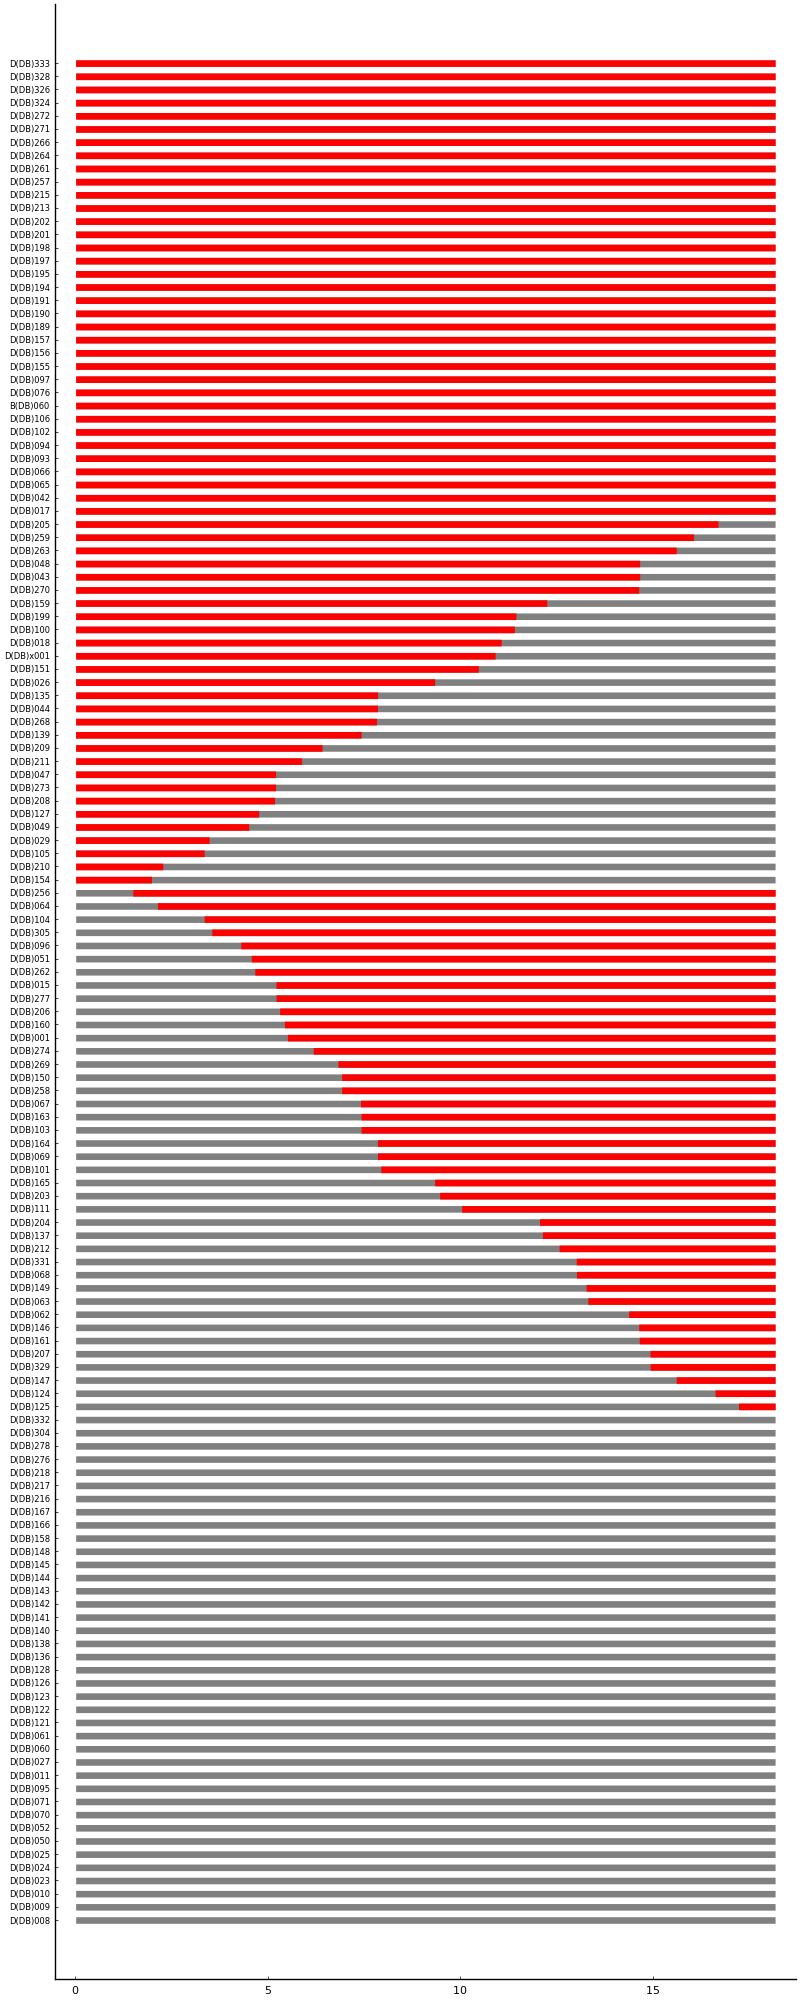

In [48]:
fig

In [49]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results"

savefig(fig,string(dir_output,"/MaternalD/Haplotypes.Z.all.png"))

In [14]:
## only showing haplotypes for unambiguously good ovaries

df_matD_ovary_scores = DataFrame(CSV.File("/n/home00/txiong/Research/2022_HybridSterility/Phenotypes/DDB_ovarian_analysis.txt"))

response_p = Array(df_matD_ovary_scores[!,9:11]);

sp_names_realGood = df_matD_ovary_scores[:,1][(response_p[:,2] .> 0) .& (response_p[:,2] .< 1)] # second dimension of response_p = Good ovary


17-element Vector{String15}:
 "D(DB)048"
 "D(DB)277"
 "D(DB)051"
 "D(DB)206"
 "D(DB)100"
 "D(DB)163"
 "D(DB)069"
 "D(DB)026"
 "D(DB)103"
 "D(DB)139"
 "D(DB)273"
 "D(DB)149"
 "D(DB)331"
 "D(DB)128"
 "D(DB)023"
 "D(DB)011"
 "D(DB)027"

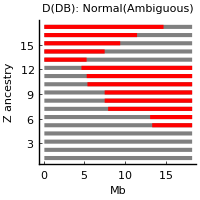

In [15]:
fig = plot(size=(200,200))

k=1

sort_order = vcat(l0,reverse(idx_01_sorted),idx_10_sorted,l1)

sample_name_sorted = sample_name[sort_order]

for i in sort_order
    
    if any(sample_name[i].==sp_names_realGood)
    
    plot!(fig,pos_subset./10^6,[0.5+ k],label="",
        seriestype=:steppre,
        linewidth=0,
        fillcolor= :gray,
        # xticks=0:1:(x_pos[end]/10^6),
        # xlims=(10,14),
        format=:png,
        fillrange=k,
        )
    
    plot!(fig,pos_subset./10^6,g_matD_subset[i,:]./2 .+ k,label="",
        seriestype=:steppre,
        linewidth=0,
        fillcolor= :red,
        xlabel="Mb",
        ylabel="Z ancestry",
        title="D(DB): Normal(Ambiguous)",
        titlefontsize=8,
        # xticks=0:1:(x_pos[end]/10^6),
        # yticks=(Array(1:size(sample_name_sorted)[1]).+0.25,sample_name_sorted),
        # ytickfontsize=6,
        # xlims=(10,14),
        xguidefontsize=8,
        yguidefontsize=8,
        format=:png,
        grid=:off,
        fillrange=k,
        )
    
    k=k+1
        
    end
end

fig

In [16]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results"

savefig(fig,string(dir_output,"/MaternalD/Haplotypes.Z.NormalAmbiguous.png"))

#### matB haplotypes on Z chromosome around locus E:

In [24]:
g_matB_sorted = g_matB[sortperm(p),:]
p_sorted = p[sortperm(p)];
sample_sorted = samples[sortperm(p)];

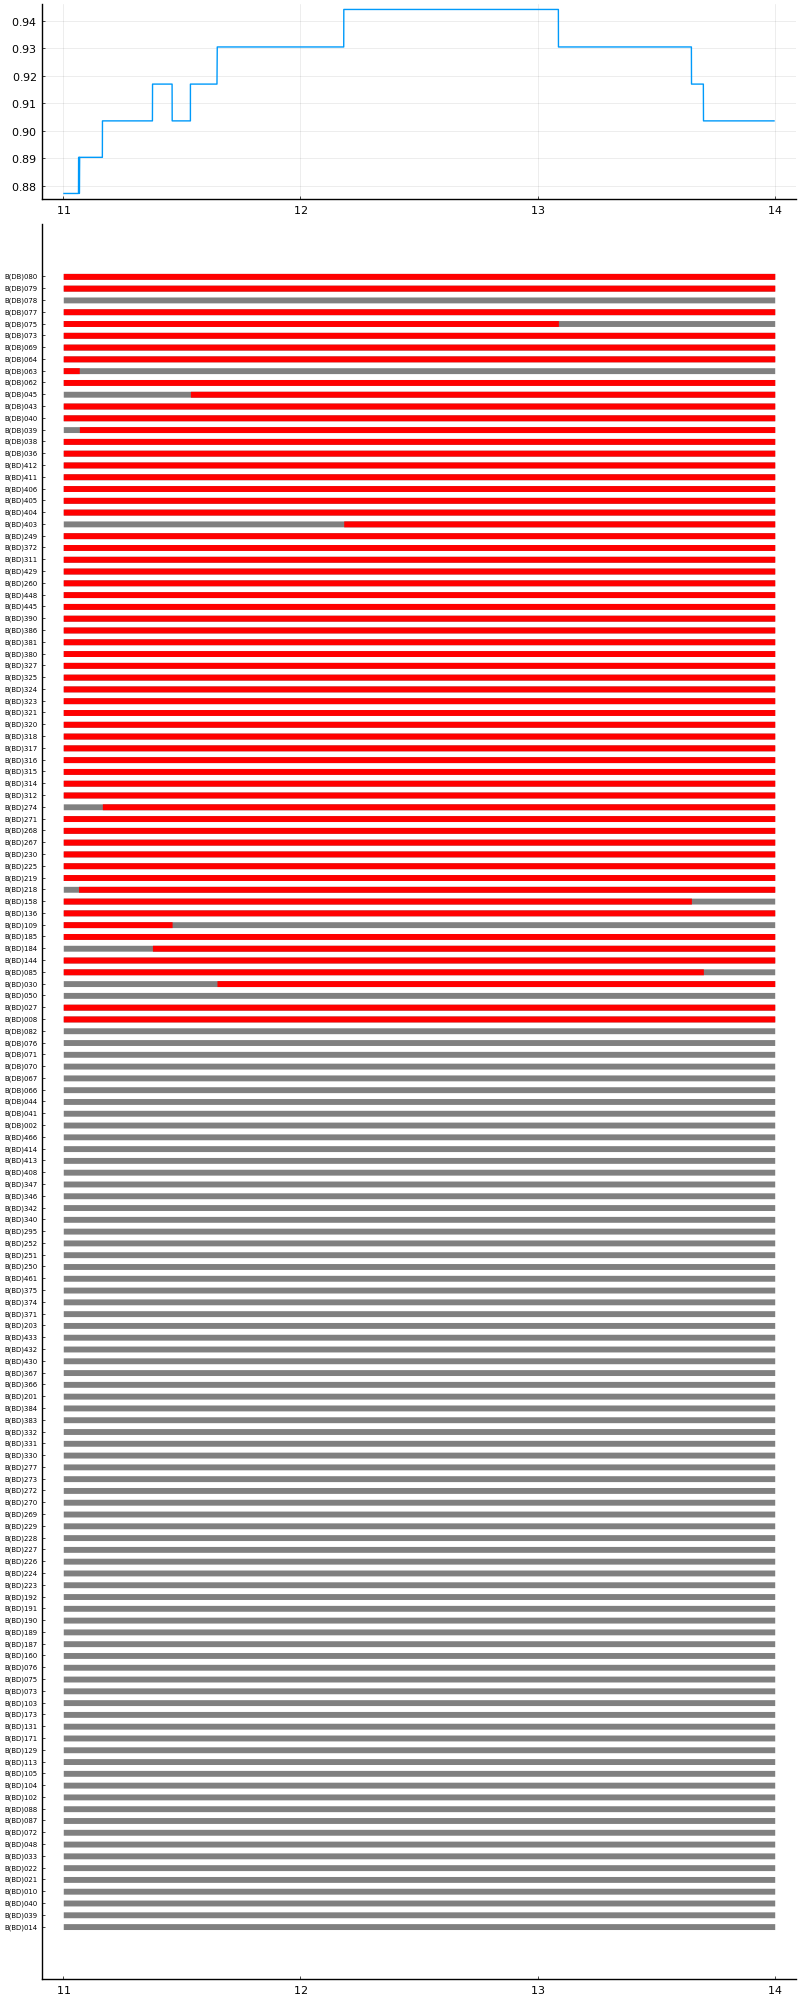

In [28]:
fig = plot(layout= @layout[a; b{0.9h}],size=(800,2000))
plot!(fig,pos[idx_pos]./10^6,abs.(β[idx_pos]),
    # ylims=(0,1),
    # xlims=(10,14),
    label="",
    markersize=1,
    markerstrokewidth=0,
    markeralpha=0.01,
    subplot=1,
    xticks=1:19)

for i in 1:size(g_matB)[1]
    
    plot!(fig,pos[idx_pos]./10^6,[0.5+ i],label="",
        seriestype=:steppre,
        linewidth=0,
        fillcolor= :gray,
        # xticks=0:1:(x_pos[end]/10^6),
        # xlims=(10,14),
        fillrange=i,
        subplot=2)
    
    plot!(fig,pos[idx_pos]./10^6,g_matB_sorted[i,idx_pos]./2 .+ i,label="",
        seriestype=:steppre,
        linewidth=0,
        fillcolor= p_sorted[i] == 1 ? :red : :blue,
        # xticks=0:1:(x_pos[end]/10^6),
        yticks=(Array(1:size(sample_sorted)[1]).+0.25,sample_sorted),
        ytickfontsize=5,
        # xlims=(10,14),
        xguidefontsize=8,
        format=:png,
        grid=:off,
        fillrange=i,
        subplot=2)
    
end

fig

In [17]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/QTL_results"

savefig(fig,string(dir_output,"/MaternalB/Haplotypes.Z.png"))

# Preparing files for rqtl-2

In [21]:
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/05.2_linkageMap.lepmap3"

cd(dir_source)

In [22]:
function get_marker_pos(chr::Int64,dir)
    
    pos = readdlm("$(dir)/call_data/data.call.with_pseudoGrandparents.fixedDiff_only.marker_positions/chr.$(chr).txt",String)
    
    return [parse(Int32,i[1]) for i in split.(pos,"*")][:,1]::Array{Int32,1}
    
end

get_marker_pos (generic function with 1 method)

In [23]:
idx_materbalB = vcat(Array(1:162),Array(213:243)) # individual indices for BC with bianor maternal genotype
idx_materbalD = vcat(Array(163:212),Array(244:335)); # individual indices for BC with dehaanii maternal genotype


#### Maternal background = B

In [5]:
pheno = DataFrame(CSV.File("/n/home00/txiong/Research/2022_HybridSterility/Phenotypes/Phenotypes_MaternalB.txt"));


In [ ]:
sample_names = pheno[:,1]

In [7]:
function get_markers_genotypes_maps_matB(chr,get_marker_pos)
    
    ancestry_file = "/ancestry.B0D1.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.0.001.F01-F16.chr.$(chr).txt"
    anc = readdlm("order_markers_results/$(ancestry_file)")
    anc = Int8.(anc);
    
    pos = get_marker_pos(chr,dir_source)


    family = "F01-F16"

    if family == "F12-F16"
        f_idx = Array(12:16)
    elseif family == "F01-F11"
        f_idx = Array(1:11)
    else
        f_idx = Array(1:16)
    end

    interference = "0.001"
    subdir = "impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

    marker_idx = []
    marker_cM = []

    open("$(dir_source)/order_markers_results/$(subdir)/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr).txt","r") do io
        i=1
        for l in eachline(io)
            if string(l[1]) != "#"
                x = split(l,"\t")
                push!(marker_idx,x[1])
                push!(marker_cM,x[2])
                i = i+1
            end
        end
    end

    marker_cM = parse.(Float32,marker_cM)
    pos = pos[parse.(Int64,marker_idx)]
    
    δ = marker_cM[2:end] .- marker_cM[1:end-1] 
    marker_idx_blockleft = vcat([1],findall(δ .> 0) .+ 1)
    g_matB_blockleft = anc[idx_materbalB,marker_idx_blockleft]
    marker_cM_blockleft = marker_cM[marker_idx_blockleft]
    pos_blockleft = pos[marker_idx_blockleft]
    
    return g_matB_blockleft,marker_cM_blockleft,pos_blockleft
    
    
end

get_markers_genotypes_maps_matB (generic function with 1 method)

In [8]:
g_dict = Dict()
map_cM_dict = Dict()
map_phy_dict = Dict()

@showprogress 1 for i in 1:30
    g,map_cM,map_phy = get_markers_genotypes_maps_matB(i,get_marker_pos)
    g_dict["$(i)"] = g
    map_cM_dict["$(i)"] = map_cM
    map_phy_dict["$(i)"] = map_phy
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:13


In [ ]:
# Z chromosome full marker ancestry (to provide information on sample Z ancestry)
ancestry_file_Z = "/ancestry.B0D1.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.0.001.F01-F16.chr.30.txt"
anc_Z = readdlm("order_markers_results/$(ancestry_file_Z)")
anc_Z = Int8.(anc_Z)

In [ ]:
# Chr 8 full marker ancestry (to provide information on sample chr8 ancestry)
ancestry_file_8 = "/ancestry.B0D1.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.0.001.F01-F16.chr.8.txt"
anc_8 = readdlm("order_markers_results/$(ancestry_file_8)")
anc_8 = Int8.(anc_8)

In [86]:
pos_Z = get_marker_pos(30,dir_source)

family = "F01-F16"

if family == "F12-F16"
    f_idx = Array(12:16)
elseif family == "F01-F11"
    f_idx = Array(1:11)
else
    f_idx = Array(1:16)
end

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"


marker_idx = []

open("$(dir_source)/order_markers_results/$(subdir)/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.0.001.F01-F16.chr.30.txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx,x[1])
            i = i+1
        end
    end
end

pos_Z = pos_Z[parse.(Int64,marker_idx)];

In [9]:
sample_selection_idx = Array(1:length(sample_names))[(.! ismissing.(pheno[!,5])) .& (occursin.("B(BD)",sample_names))];

println(length(sample_selection_idx))

128


In [10]:
## write marker genetic map file

dir_output = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB"

open("$(dir_output)/map.genetic.csv","w") do file
    write(file,"marker,chr,pos\n")
    for chr in 1:30
        marker_pos = map_phy_dict["$(chr)"]
        marker_genetic = map_cM_dict["$(chr)"]
        for j in 1:size(marker_pos)[1]
            marker_name = string("$(chr)_",string(marker_pos[j]))
            
            write(file,string("$(marker_name),$(chr),",string(marker_genetic[j]),"\n"))
        end
    end
end


In [11]:
## write marker physical map file

dir_output = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB"

open("$(dir_output)/map.physical.csv","w") do file
    write(file,"marker,chr,pos\n")
    for chr in 1:30
        marker_pos = map_phy_dict["$(chr)"]
        for j in 1:size(marker_pos)[1]
            marker_name = string("$(chr)_",string(marker_pos[j]))
            write(file,string("$(marker_name),$(chr),",string(marker_pos[j]/1E6),"\n"))
        end
    end
end


In [12]:
## write genotype file

dir_output = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB"

g_all = []

marker_name_all = []

for chr in 1:30
    
    push!(g_all,g_dict["$(chr)"])
    marker_pos = map_phy_dict["$(chr)"]
    push!(marker_name_all,[string("$(chr)_",marker_pos[i]) for i in 1:size(marker_pos)[1]])
    
end

marker_name_all = cat(marker_name_all...,dims=1)
g_all = cat(g_all...,dims=2);

open("$(dir_output)/genotypes.csv","w") do file
    
    write(file,string("id,",join(marker_name_all,","),"\n"))
    
    for i in sample_selection_idx
        line = []
        push!(line,sample_names[i])
        for j in g_all[i,:]
            if j == 1
                push!(line,"DB")
            else
                push!(line,"BB")
            end
        end
        write(file,string(join(line,","),"\n"))
    end

end

In [ ]:
pheno

In [14]:
## phenotypes

p1 = pheno[:,5]
# p2 = Int.((pheno[:,2] .== 0) .& (pheno[:,3] .== 0) .& (pheno[:,4] .== 1));

In [16]:
## Phenotype file

dir_output = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB"

open(string("$(dir_output)/phenotypes.csv"),"w") do file
    
    write(file,"id,Pupal_Weight\n")
    
    for i in sample_selection_idx
        
        write(file,join(string.([sample_names[i],p1[i]]),","))
        write(file,"\n")
    end
    
end

In [17]:
## individual covariates

c1 = pheno[:,6];
c2 = Int.(zeros(size(c1)));

for i in 1:length(c1)
    c = c1[i]
    
    if c == "I"
        c2[i] = 1
    elseif c == "II"
        c2[i] = 2
    elseif c == "III"
        c2[i] = 3
    elseif c == "IV"
        c2[i] = 4
    end
end

In [18]:
## Covariate file

dir_output = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matB"

open(string("$(dir_output)/covariates.csv"),"w") do file
    
    write(file,"id,Brood\n")
    
    for i in sample_selection_idx
        
        write(file,join(string.([sample_names[i],c1[i]]),","))
        write(file,"\n")
    end
    
end

#### Maternal background = D

In [24]:
pheno = DataFrame(CSV.File("/n/home00/txiong/Research/2022_HybridSterility/Phenotypes/Phenotypes_MaternalD_v2.txt"));


In [25]:
sample_names = pheno[:,1];

In [ ]:
# optional: a list that contains samples to be included
samples_to_include = readdlm("/n/home00/txiong/Research/2022_HybridSterility/Phenotypes/sample_names_to_include.txt")[:,1]
samples_to_include_pheno01 = readdlm("/n/home00/txiong/Research/2022_HybridSterility/Phenotypes/sample_names_to_include_phenotypes-01.txt")[:,1]
samples_to_include_pheno02 = readdlm("/n/home00/txiong/Research/2022_HybridSterility/Phenotypes/sample_names_to_include_phenotypes-02.txt")[:,1]

samples_to_include_pheno01 = Int.(samples_to_include_pheno01)
samples_to_include_pheno02 = Int.(samples_to_include_pheno02)



In [26]:
function get_markers_genotypes_maps_matD(chr,get_marker_pos)
    
    ancestry_file = "/ancestry.B0D1.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.0.001.F01-F16.chr.$(chr).txt"
    anc = readdlm("order_markers_results/$(ancestry_file)")
    anc = Int8.(anc);
    
    pos = get_marker_pos(chr,dir_source)


    family = "F01-F16"

    if family == "F12-F16"
        f_idx = Array(12:16)
    elseif family == "F01-F11"
        f_idx = Array(1:11)
    else
        f_idx = Array(1:16)
    end

    interference = "0.001"
    subdir = "impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

    marker_idx = []
    marker_cM = []

    open("$(dir_source)/order_markers_results/$(subdir)/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr).txt","r") do io
        i=1
        for l in eachline(io)
            if string(l[1]) != "#"
                x = split(l,"\t")
                push!(marker_idx,x[1])
                push!(marker_cM,x[2])
                i = i+1
            end
        end
    end

    marker_cM = parse.(Float32,marker_cM)
    pos = pos[parse.(Int64,marker_idx)]
    
    δ = marker_cM[2:end] .- marker_cM[1:end-1] 
    marker_idx_blockleft = vcat([1],findall(δ .> 0) .+ 1)
    g_matD_blockleft = anc[idx_materbalD,marker_idx_blockleft]
    marker_cM_blockleft = marker_cM[marker_idx_blockleft]
    pos_blockleft = pos[marker_idx_blockleft]
    
    return g_matD_blockleft,marker_cM_blockleft,pos_blockleft
    
    
end

get_markers_genotypes_maps_matD (generic function with 1 method)

In [27]:
g_dict = Dict()
map_cM_dict = Dict()
map_phy_dict = Dict()

@showprogress 1 for i in 1:30
    g,map_cM,map_phy = get_markers_genotypes_maps_matD(i,get_marker_pos)
    g_dict["$(i)"] = g
    map_cM_dict["$(i)"] = map_cM
    map_phy_dict["$(i)"] = map_phy
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:45


In [28]:
sample_selection_idx = Array(1:length(sample_names))#[[any(s .== samples_to_include) for s in sample_names]];

println(length(sample_selection_idx))

142


In [29]:
## write marker genetic map file

dir_output = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matD"

open("$(dir_output)/map.genetic.csv","w") do file
    write(file,"marker,chr,pos\n")
    for chr in 1:30
        marker_pos = map_phy_dict["$(chr)"]
        marker_genetic = map_cM_dict["$(chr)"]
        for j in 1:size(marker_pos)[1]
            marker_name = string("$(chr)_",string(marker_pos[j]))
            
            write(file,string("$(marker_name),$(chr),",string(marker_genetic[j]),"\n"))
        end
    end
end

In [30]:
## write marker physical map file

dir_output = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matD"

open("$(dir_output)/map.physical.csv","w") do file
    write(file,"marker,chr,pos\n")
    for chr in 1:30
        marker_pos = map_phy_dict["$(chr)"]
        for j in 1:size(marker_pos)[1]
            marker_name = string("$(chr)_",string(marker_pos[j]))
            write(file,string("$(marker_name),$(chr),",string(marker_pos[j]/1E6),"\n"))
        end
    end
end

In [31]:
## write genotype file - step 1

dir_output = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matD"

g_all = []

marker_name_all = []

for chr in 1:30
    
    push!(g_all,g_dict["$(chr)"])
    marker_pos = map_phy_dict["$(chr)"]
    push!(marker_name_all,[string("$(chr)_",marker_pos[i]) for i in 1:size(marker_pos)[1]])
    
end

marker_name_all = cat(marker_name_all...,dims=1)
g_all = cat(g_all...,dims=2);

In [32]:
## write genotype file - step 2

open("$(dir_output)/genotypes.csv","w") do file
    
    write(file,string("id,",join(marker_name_all,","),"\n"))
    
    for i in sample_selection_idx
        line = []
        push!(line,sample_names[i])
        for j in g_all[i,:]
            if j == 1
                push!(line,"DD")
            else
                push!(line,"DB")
            end
        end
        write(file,string(join(line,","),"\n"))
    end
    
    # optional, write additional lines manually into the genotype file (e.g., creating dummy individuals)
    
    # line = []
    # push!(line,"DB_F1")
    # for j in 1:size(g_all)[2]
    #     push!(line,"DB")
    # end
    # write(file,string(join(line,","),"\n"))
    
    
end

In [ ]:
## phenotypes

# if you use a subset of samples with customized phenotypes

# p1 = [samples_to_include_pheno01[findfirst(x->x==sample_names[i],samples_to_include)] for i in sample_selection_idx];
# p2 = [samples_to_include_pheno02[findfirst(x->x==sample_names[i],samples_to_include)] for i in sample_selection_idx];


# if you use phenotypes directly from the pheno dataframe

p1 = pheno[:,4]
p2 = pheno[:,5]
p3 = pheno[:,6]
p4 = pheno[:,7]
p5 = pheno[:,8]
p6 = pheno[:,9]

In [39]:
## Phenotype file

dir_output = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matD"

open(string("$(dir_output)/phenotypes.csv"),"w") do file
    
    write(file,"id,Dimi_InAmb,Dimi_ExAmb,Good_InAmb,Good_ExAmb,Jamm_InAmb,Jamm_ExAmb\n")
    
    k = 1
    
    for i in sample_selection_idx
        
        write(file,join(string.([sample_names[i],p1[k],p2[k],p3[k],p4[k],p5[k],p6[k]]),","))
        write(file,"\n")
        
        k=k+1
    end
    
    # optional, write additional lines manually into the phenotype file (e.g., creating dummy individuals)
    
    # write(file,"DB_F1,0\n")
    
end

In [40]:
## individual covariates

c1 = pheno[:,3];

In [41]:
## Covariate file

dir_output = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/07_qtl.rqtl2/data/matD"

open(string("$(dir_output)/covariates.csv"),"w") do file
    
    write(file,"id,Brood\n")
    
    for i in sample_selection_idx
        
        write(file,join(string.([sample_names[i],c1[i]]),","))
        write(file,"\n")
    end
    
end

# Z chromosome sequence properties

In [2]:
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/03.2_call.bcftools/vcfs"

cd(dir_source)

In [3]:
pos = []
gt = []
open(`zcat Joint.Z.snp+novar.noMiss.filtered1.simple_annotation.grandparents.vcf.gz`) do io
    
    for l in eachline(io)
        if string(l[1])!="#"
            info = split(l,"\t")
            push!(pos,info[2])
            push!(gt,info[10:end])
        end
    end

end
pos=parse.(Int,pos);

In [4]:
alleles = []
for g in gt
    
    push!(alleles,[split.(i,":")[1] for i in g])
    
end
alleles=hcat(alleles...);

In [28]:
group1 = [1,2,3]
group2 = [4,5,6]

function allele_array_to_frequency(allele_array,alleles)
    N = length(allele_array)
    return [sum(allele_array .== a)/N for a in alleles]
end

function get_dxy(alleles_matrix,group1,group2,allele_array_to_frequency)
    
    x = split.(alleles_matrix[group1,:],"/")
    y = split.(alleles_matrix[group2,:],"/")
    
    x = [vcat(x[:,i]...) for i in 1:size(x)[2]]
    y = [vcat(y[:,i]...) for i in 1:size(y)[2]]
    
    
    px = [allele_array_to_frequency(x0,["0","1","2"]) for x0 in x]
    py = [allele_array_to_frequency(y0,["0","1","2"]) for y0 in y]
    
    return mean([1 - sum(px[i] .* py[i]) for i in 1:length(px)])
    
end

function get_dxy_firstRandomHaplotype(alleles_matrix,group1,group2,allele_array_to_frequency)
    
    x = split.(alleles_matrix[group1[1],:],"/")
    y = split.(alleles_matrix[group2[1],:],"/")
    
    x = rand.(x)
    y = rand.(y)
    
    
    px = [allele_array_to_frequency([x0],["0","1","2"]) for x0 in x]
    py = [allele_array_to_frequency([y0],["0","1","2"]) for y0 in y]
    
    return mean([1 - sum(px[i] .* py[i]) for i in 1:length(px)])
    
end

get_dxy_firstRandomHaplotype (generic function with 1 method)

In [21]:
## for whole chromosome
left_margins = Int.(Array(1:5E4:maximum(pos)))
right_margins = Int.(left_margins .+ (5E4 - 1))
mid_points = (left_margins .+ right_margins)./2;

## for a specific region
# left_margins = Int.(Array(11850000:1000:11950000))
# right_margins = Int.(left_margins .+ (1000 - 1))
# mid_points = (left_margins .+ right_margins)./2;

In [ ]:
Dxy = []
@showprogress 1 for i in 1:length(left_margins)
    idx = (pos .>= left_margins[i]) .& (pos .<= right_margins[i])
    if sum(idx) .== 0
        push!(Dxy,NaN)
    else
        push!(Dxy,get_dxy(alleles[:,idx],group1,group2,allele_array_to_frequency))
    end
end

println(mean(Dxy))

In [ ]:
Dxy_dict = Dict()

for chr in vcat(string.("HiC_scaffold_",1:29),["Z"])
    
    println(chr)

    pos = []
    gt = []
    open(`zcat Joint.$(chr).snp+novar.noMiss.filtered1.simple_annotation.grandparents.vcf.gz`) do io

        for l in eachline(io)
            if string(l[1])!="#"
                info = split(l,"\t")
                push!(pos,info[2])
                push!(gt,info[10:end])
            end
        end

    end
    pos=parse.(Int,pos);
    
    alleles = []
    for g in gt

        push!(alleles,[split.(i,":")[1] for i in g])

    end
    alleles=hcat(alleles...);
    
    Dxy = []
    @showprogress 1 for i in 1:length(left_margins)
        idx = (pos .>= left_margins[i]) .& (pos .<= right_margins[i])
        if sum(idx) .== 0
            push!(Dxy,NaN)
        else
            push!(Dxy,get_dxy_firstRandomHaplotype(alleles[:,idx],group1,group2,allele_array_to_frequency))
        end
    end
    
    Dxy_dict["$(chr)"]=Dxy
    
end

In [30]:
JLD.save("/n/boslfs02/LABS/mallet_lab/Lab/txiong/Research/2022_HybridSterility/Results/Dxy/Dxy.w50kbs50kb.grandparents.firstRandomHaplotype.jld","Dxy_dict",Dxy_dict)


In [2]:
using StatsPlots

In [ ]:
Dxy_data = JLD.load("/n/boslfs02/LABS/mallet_lab/Lab/txiong/Research/2022_HybridSterility/Results/Dxy/Dxy.w50kbs50kb.grandparents.jld")
Dxy_dict = Dxy_data["Dxy_dict"]


In [ ]:
dxy_auto = vcat([Dxy_dict["HiC_scaffold_$(i)"] for i in 1:29]...)
dxy_auto = dxy_auto[.!isnan.(dxy_auto)]

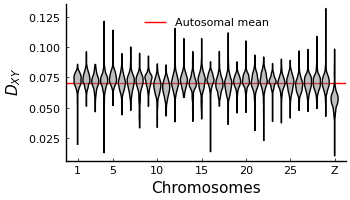

In [14]:
fig = plot(size=(350,200))

hline!(fig,[mean(dxy_auto)],linecolor=:red,label="Autosomal mean",
    legend_position=:top,
    legend_background_color=false)

for i in 1:30
    
    chr = i==30 ? "Z" : "HiC_scaffold_$(i)"
    
    dxy = Dxy_dict[chr][.!isnan.(Dxy_dict[chr])]
    
    violin!(fig,[i],dxy,
        grid=:off,
        xlabel="Chromosomes",
        color=:gray,
        fillalpha=0.5,
        xtickfontsize=8,
        xticks=([1,5,10,15,20,25,30],["1","5","10","15","20","25","Z"]),
        ytickfontsize=8,
        ylabel=L"D_{XY}",
        label="")

end

fig

In [15]:
dir_output = "/n/home00/txiong/Research/2022_HybridSterility/GenomicPopGen/Dxy"

prefix = "Dxy.w50kbs50kb.grandparents"
savefig(fig,"$(dir_output)/$(prefix).pdf")
savefig(fig,"$(dir_output)/$(prefix).png")



#### Copy Number Variation

In [35]:
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/08_annotations"

df = DataFrame(CSV.File("$(dir_source)/Pb_EVM.RefV2.HiC_scaffold_30.sorted.CDS.coverage_perbase",header=false))

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,String15,String3,String3,Int64,Int64,String1,String1,Int64
1,HiC_scaffold_30,EVM,CDS,91551,91703,.,+,0
2,HiC_scaffold_30,EVM,CDS,91551,91703,.,+,0
3,HiC_scaffold_30,EVM,CDS,91551,91703,.,+,0
4,HiC_scaffold_30,EVM,CDS,91551,91703,.,+,0
5,HiC_scaffold_30,EVM,CDS,91551,91703,.,+,0
6,HiC_scaffold_30,EVM,CDS,91551,91703,.,+,0
7,HiC_scaffold_30,EVM,CDS,91551,91703,.,+,0
8,HiC_scaffold_30,EVM,CDS,91551,91703,.,+,0
9,HiC_scaffold_30,EVM,CDS,91551,91703,.,+,0


In [65]:
rel_pos = df[:,10]
c = df[:,11]
c_m = median(c);
gene = unique(df[:,9]);

In [49]:
feature_start = Array(1:length(rel_pos))[rel_pos .== 1]
feature_end = append!((feature_start .- 1)[2:end],[length(rel_pos)]);

In [71]:
relative_cov=[]

for i in 1:length(gene)

    gene_name = gene[i]

    y = c[df[:,9] .== gene_name]

    push!(relative_cov,mean(y ./ c_m))
    
end

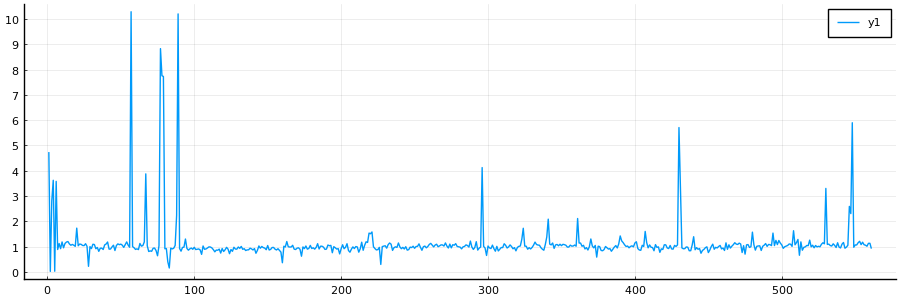

In [92]:
plot(relative_cov,yticks=0:10,size=(900,300))

In [86]:
gene_name_with_increased_coverage = gene[relative_cov .> 2]

gene_name_with_increased_coverage = [split(split(i,";")[1],"=")[2] for i in gene_name_with_increased_coverage]

20-element Vector{SubString{String31}}:
 "Pb_12894"
 "Pb_12896"
 "Pb_12897"
 "Pb_12899"
 "Pb_12950"
 "Pb_12960"
 "Pb_12970"
 "Pb_12971"
 "Pb_12972"
 "Pb_12981"
 "Pb_12982"
 "Pb_13389"
 "Pb_13344"
 "Pb_13324"
 "Pb_13255"
 "Pb_13254"
 "Pb_13155"
 "Pb_13139"
 "Pb_13138"
 "Pb_13137"

In [105]:
for i in 1:length(gene_name_with_increased_coverage)
    println([gene_name_with_increased_coverage[i],relative_cov[relative_cov .> 2][i]])
end

Any["Pb_12894", 4.737764079869344]
Any["Pb_12896", 2.8080466830466824]
Any["Pb_12897", 3.622783160519011]
Any["Pb_12899", 3.578972589610887]
Any["Pb_12950", 10.286272286272286]
Any["Pb_12960", 3.876076477278882]
Any["Pb_12970", 8.827733138543948]
Any["Pb_12971", 7.755773142869917]
Any["Pb_12972", 7.7265802387753615]
Any["Pb_12981", 2.2378625361654088]
Any["Pb_12982", 10.200197388399637]
Any["Pb_13389", 4.125130944898387]
Any["Pb_13344", 2.085864502273171]
Any["Pb_13324", 2.111450159837257]
Any["Pb_13255", 5.707280121848467]
Any["Pb_13254", 3.267896742896744]
Any["Pb_13155", 3.300945945945946]
Any["Pb_13139", 2.5900363965498063]
Any["Pb_13138", 2.3053053053053048]
Any["Pb_13137", 5.897728714630123]


In [87]:
dir_output = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/08_annotations"

open("$(dir_output)/genes_with_increasedCN_inD.list","w") do file
    write(file,join(gene_name_with_increased_coverage,"\n"))
end

179